In [68]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm
import sklearn.metrics
from sklearn.metrics import classification_report,accuracy_score,precision_recall_fscore_support

In [2]:
ETHNICITIES = ['African','Asian (East)', 'Asian (South)','Caucasian (American)','Caucasian (European)']
GENDERS = ['men','women']
METHODS = ['wav2lip','fsgan','faceswap']

# Read and Gather Predictions for Each Model

In [3]:
def get_id(path):
    return path.split('/')[-2]
    
def get_filename(path):
    return path.split('/')[-1]


def get_method(df,meta_df):
    """
        get deepfake generation method
    """
    
    methods = ['real'] * len(df)
    for index, row in df.iterrows():
        if row['label'] == 0:
            continue
            
        cond = (meta_df['source'] == row['source_id']) & (meta_df['path'] == row['filename'])
        method = meta_df[cond]['method'].values[0]
        methods[index] = method
        
    return methods

In [4]:
def filter_predictions(df,method):
    
    real_ids = df[df['label'] == 0]['source_id']
    fake_ids = df[(df['label'] == 1) & (df['method'] == method)]['source_id']
    fake_indices = []
    for real_id in real_ids:
        ids = fake_ids[fake_ids == real_id]
        if len(ids) > 0:
            fake_indices.append(ids.index[0])
    
    indices = list(real_ids.index) + fake_indices
    df =  df.iloc[indices].reset_index()
    df = df.drop(columns=['index'])
    return df
    

In [5]:
## Read prediction files for each model and join real and fake results
result_dir = './Predictions/pred_ensembles'
df_dict = {}
meta_df = pd.read_csv('./FakeAVCeleb_v1.2/meta_data.csv')
for model_name in os.listdir(result_dir):
    if '.DS_' in model_name:
        continue
    df_list = []
    for cat in os.listdir(os.path.join(result_dir,model_name)):
        if '.DS_' in cat:
            continue
        for ethnicity in os.listdir(os.path.join(result_dir,model_name,cat)):
            if '.DS_' in ethnicity:
                continue
            for gender in os.listdir(os.path.join(result_dir,model_name,cat,ethnicity)):
                if '.DS_' in gender:
                    continue
                
                path_df = os.path.join(result_dir,model_name,cat,ethnicity,gender,'results.csv')
                df = pd.read_csv(path_df)
                df_list.append(df)


    # concatenate all dfs for a model
    model_df = pd.concat(df_list).reset_index()
    model_df['path'] = model_df['path'].astype(str)
    model_df['source_id'] = model_df['path'].apply(get_id)
    model_df['filename'] = model_df['path'].apply(get_filename)
    model_df['method'] = get_method(model_df,meta_df)
    model_df = model_df.drop(columns=['index'])
    df_dict[model_name[4:]] = model_df


In [127]:
def get_label(path):
    if 'RealVideo' in path:
        return 0
    else:
        return 1

df_cvit = pd.read_csv('./preds_cross_efficient_transformer.txt')
df_cvit = df_cvit.rename(columns={'video_name':'path'})
df_cvit['path'] = df_cvit['path'].astype(str)
df_cvit['label'] = df_cvit['path'].apply(get_label)
df_cvit['source_id'] = df_cvit['path'].apply(get_id)
df_cvit['filename'] = df_cvit['path'].apply(get_filename)
df_cvit['method'] = get_method(df_cvit,meta_df)
df_cvit['gender'] = df_cvit['path'].apply(lambda x : x.split('/')[-3])
df_cvit['ethnicity'] = df_cvit['path'].apply(lambda x : x.split('/')[-4])

df_dict['CrossEffViT_DFDC_FFPP'] = df_cvit

In [129]:
df_dict.keys()

dict_keys(['EfficientNetB4_DFDC', 'EfficientNetB4_FFPP', 'EfficientNetAutoAttnB4_DFDC', 'EfficientNetB4ST_FFPP', 'Xception_DFDC', 'EfficientNetAutoAttnB4ST_FFPP', 'EfficientNetAutoAttnB4ST_DFDC', 'EfficientNetAutoAttnB4_FFPP', 'EfficientNetB4ST_DFDC', 'Xception_FFPP', 'CrossEffViT_DFDC_FFPP'])

Since we have an imbalanced dataset, we choose only one fake generated video against each real video for each generation method. We will evaluate the results on the three different generation methods separately. 

In [7]:
METHOD = 'faceswap'
for k in df_dict.keys():
    df_dict[k] = filter_predictions(df_dict[k],method = METHOD)

### Functions

In [131]:
def get_accuracy_scores(df,thresh = 0.5):
    
    preds_proba = df['pred'].to_numpy()
    preds = np.where(preds_proba >= thresh,1,0)
    
    labels = df['label'].to_numpy()
    stats = precision_recall_fscore_support(labels,preds)
    fpr,tpr,thresholds = sklearn.metrics.roc_curve(labels,preds_proba,pos_label=1)
    auc = sklearn.metrics.roc_auc_score(labels,preds_proba)
    stats_dict= {
        'precision_0' : stats[0][0],
        'precision_1' : stats[0][1],
        'recall_0' : stats[1][0],
        'recall_1' : stats[1][1],
        'f1_0': stats[2][0],
        'f1_1' : stats[2][1],
        'tpr': tpr,
        'fpr': fpr,
        'thresholds-roc': thresholds,
        'auc-roc':auc
    }
    
    
    return accuracy_score(labels,preds),stats_dict

def get_accuracy_scores_ethnicity(df,ethnicity,thresh=0.5):
    cond = df['ethnicity'] == ethnicity
    df_filter = df[cond]
    acc,stats_dict = get_accuracy_scores(df_filter,thresh)
    return acc,stats_dict

def get_accuracy_scores_gender(df,gender,thresh=0.5):
    cond = df['gender'] == gender
    df_filter = df[cond]
    
    acc,stats_dict = get_accuracy_scores(df_filter,thresh)
    return acc,stats_dict


def get_accuracy_scores_ethnicity_gender(df,ethnicity,gender,thresh=0.5):
    cond = (df['gender'] == gender) & (df['ethnicity'] == ethnicity)
    df_filter = df[cond]
    
    acc,stats_dict = get_accuracy_scores(df_filter,thresh)
    return acc,stats_dict


# Accuracy Analysis

### Accuracy of Each Model Overall

In [132]:
accs = []
datasets = []
model_names = []
precision_0 = []
precision_1 = []
recall_0 = []
recall_1 = []
f1_0 = []
f1_1 = []
tpr = []
fpr = []
thresholds_roc=[]
auc_roc = []

for model_name,df in df_dict.items():
    acc,stats_dict = get_accuracy_scores(df)
    accs.append(acc)
    precision_0.append(stats_dict['precision_0'])
    precision_1.append(stats_dict['precision_1'])
    recall_0.append(stats_dict['recall_0'])
    recall_1.append(stats_dict['recall_1'])
    f1_0.append(stats_dict['f1_0'])
    f1_1.append(stats_dict['f1_1'])
    tpr.append(stats_dict['tpr'])
    fpr.append(stats_dict['fpr'])
    thresholds_roc.append(stats_dict['thresholds-roc'])
    auc_roc.append(stats_dict['auc-roc'])
    
    if model_name.startswith('CrossEff'):
        datasets.append('DFDC_FFPP')
        model_names.append('CrossEffViT')
    else:
        datasets.append(model_name.split('_')[-1])
        model_names.append(model_name.split('_')[0])

accuracy_df = pd.DataFrame({
    'model': model_names,
    'training_dataset':datasets,
    'accuracy': accs,
    'precision_0' : precision_0,
    'precision_1' : precision_1,
    'recall_0' : recall_0,
    'recall_1' : recall_1,
    'f1_0': f1_0,
    'f1_1' : f1_1,
    'tpr': tpr,
    'fpr': fpr,
    'thresholds-roc': thresholds_roc,
    'auc-roc':auc_roc
})

accuracy_df.sort_values(by=['auc-roc'])

,model,training_dataset,accuracy,precision_0,precision_1,recall_0,recall_1,f1_0,f1_1,tpr,fpr,thresholds-roc,auc-roc
6,EfficientNetAutoAttnB4ST,DFDC,0.823779,0.941799,0.744681,0.712,0.950226,0.810934,0.834990,"[0.0, 0.0022624434389140274, 0.011312217194570...","[0.0, 0.0, 0.0, 0.002, 0.002, 0.006, 0.006, 0....","[1.97796327, 0.97796327, 0.97631615, 0.9757229...",0.948810
8,EfficientNetB4ST,DFDC,0.845011,0.956186,0.767148,0.742,0.961538,0.835586,0.853414,"[0.0, 0.0022624434389140274, 0.185520361990950...","[0.0, 0.0, 0.0, 0.002, 0.002, 0.002, 0.002, 0....","[1.9873392600000002, 0.98733926, 0.9652713, 0....",0.954199
0,EfficientNetB4,DFDC,0.796178,0.966667,0.704248,0.638,0.975113,0.768675,0.817837,"[0.0, 0.0022624434389140274, 0.511312217194570...","[0.0, 0.0, 0.0, 0.002, 0.002, 0.004, 0.004, 0....","[1.9998928299999998, 0.99989283, 0.99162453, 0...",0.962434
2,EfficientNetAutoAttnB4,DFDC,0.835456,0.970027,0.749565,0.712,0.975113,0.821223,0.847591,"[0.0, 0.0022624434389140274, 0.545248868778280...","[0.0, 0.0, 0.0, 0.002, 0.002, 0.004, 0.004, 0....","[1.9997342, 0.9997342, 0.9871272, 0.9869398, 0...",0.969186
4,Xception,DFDC,0.908705,0.942308,0.875527,0.882,0.938914,0.911157,0.906114,"[0.0, 0.0022624434389140274, 0.355203619909502...","[0.0, 0.0, 0.0, 0.002, 0.002, 0.004, 0.004, 0....","[1.9993650299999999, 0.99936503, 0.98834115, 0...",0.969946
9,Xception,FFPP,0.939490,0.958592,0.919390,0.926,0.954751,0.942014,0.936737,"[0.0, 0.0022624434389140274, 0.554298642533936...","[0.0, 0.0, 0.0, 0.002, 0.002, 0.006, 0.006, 0....","[1.99834526, 0.99834526, 0.9487316, 0.9486518,...",0.984000
7,EfficientNetAutoAttnB4,FFPP,0.945860,0.960986,0.929670,0.936,0.957014,0.948328,0.943144,"[0.0, 0.0022624434389140274, 0.450226244343891...","[0.0, 0.0, 0.0, 0.002, 0.002, 0.004, 0.004, 0....","[1.99919087, 0.99919087, 0.9624832, 0.9613452,...",0.988873
5,EfficientNetAutoAttnB4ST,FFPP,0.950106,0.953908,0.945824,0.952,0.947964,0.952953,0.946893,"[0.0, 0.0022624434389140274, 0.746606334841629...","[0.0, 0.0, 0.0, 0.002, 0.002, 0.004, 0.004, 0....","[1.98407966, 0.98407966, 0.8107182, 0.81034005...",0.992199
3,EfficientNetB4ST,FFPP,0.942675,0.978541,0.907563,0.912,0.977376,0.944099,0.941176,"[0.0, 0.0022624434389140274, 0.819004524886877...","[0.0, 0.0, 0.0, 0.002, 0.002, 0.004, 0.004, 0....","[1.99911076, 0.99911076, 0.8714834, 0.8694447,...",0.993498
1,EfficientNetB4,FFPP,0.951168,0.985043,0.917722,0.922,0.984163,0.952479,0.949782,"[0.0, 0.0022624434389140274, 0.705882352941176...","[0.0, 0.0, 0.0, 0.002, 0.002, 0.004, 0.004, 0....","[1.9997248, 0.9997248, 0.9436163, 0.9435221, 0...",0.994163


In [169]:
cols_to_use = ['model',	'training_dataset',	'accuracy',	'precision_0','precision_1','recall_0',	'recall_1','f1_0', 'f1_1','auc-roc']
accuracy_df = accuracy_df.round(decimals=2)
accuracy_df[cols_to_use].to_csv('./tables/overall_faceswap.csv',index=False)

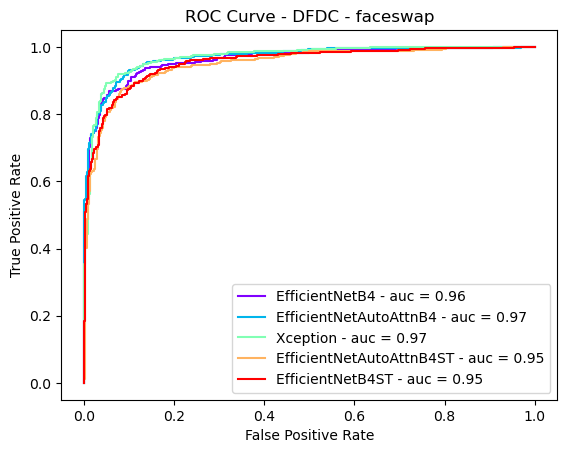

In [108]:
# plot roc curves
plt.style.use('default')
plt.figure()
temp_df = accuracy_df[accuracy_df['training_dataset'] == 'DFDC']
colors = iter(cm.rainbow(np.linspace(0, 1, len(temp_df))))
for i,row in temp_df.iterrows():
    tpr = row['tpr']
    fpr = row['fpr']
    auc = row['auc-roc']
    l = row['model']  + ' - auc = ' + str(str(round(auc, 2)))
    plt.plot(fpr,tpr,color=next(colors),label = l)
    
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - DFDC - faceswap")
plt.legend(loc="lower right")
plt.show()

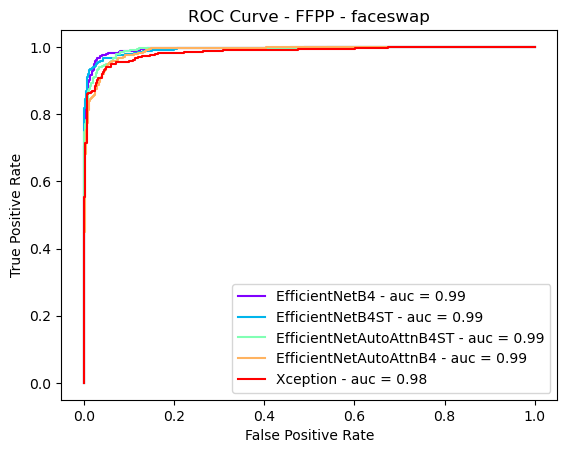

In [109]:
# plot roc curves
plt.style.use('default')
plt.figure()
temp_df = accuracy_df[accuracy_df['training_dataset'] == 'FFPP']
colors = iter(cm.rainbow(np.linspace(0, 1, len(temp_df))))
for i,row in temp_df.iterrows():
    tpr = row['tpr']
    fpr = row['fpr']
    auc = row['auc-roc']
    l = row['model']  + ' - auc = ' + str(str(round(auc, 2)))
    plt.plot(fpr,tpr,color=next(colors),label = l)
    
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - FFPP - faceswap")
plt.legend(loc="lower right")
plt.show()

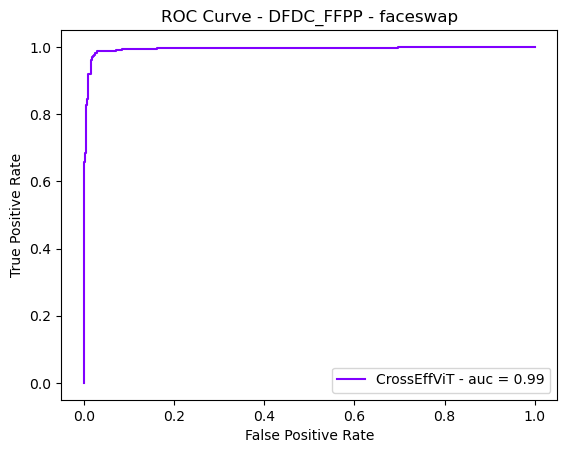

In [133]:
plt.style.use('default')
plt.figure()
temp_df = accuracy_df[accuracy_df['training_dataset'] == 'DFDC_FFPP']
colors = iter(cm.rainbow(np.linspace(0, 1, len(temp_df))))
for i,row in temp_df.iterrows():
    tpr = row['tpr']
    fpr = row['fpr']
    auc = row['auc-roc']
    l = row['model']  + ' - auc = ' + str(str(round(auc, 2)))
    plt.plot(fpr,tpr,color=next(colors),label = l)
    
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - DFDC_FFPP - faceswap")
plt.legend(loc="lower right")
plt.show()

## Ethnic Group

In [175]:
accs = []
datasets = []
ethnics = []
model_names = []
precision_0 = []
precision_1 = []
recall_0 = []
recall_1 = []
f1_0 = []
f1_1 = []
tpr = []
fpr = []
thresholds_roc=[]
auc_roc = []
for model_name,df in df_dict.items():
    
    for eth in ETHNICITIES:
        acc,stats_dict = get_accuracy_scores_ethnicity(df,eth)
        ethnics.append(eth)
        accs.append(acc)
        precision_0.append(stats_dict['precision_0'])
        precision_1.append(stats_dict['precision_1'])
        recall_0.append(stats_dict['recall_0'])
        recall_1.append(stats_dict['recall_1'])
        f1_0.append(stats_dict['f1_0'])
        f1_1.append(stats_dict['f1_1'])
        tpr.append(stats_dict['tpr'])
        fpr.append(stats_dict['fpr'])
        thresholds_roc.append(stats_dict['thresholds-roc'])
        auc_roc.append(stats_dict['auc-roc'])

        if model_name.startswith('CrossEff'):
            datasets.append('DFDC_FFPP')
            model_names.append('CrossEffViT')
        else:
            datasets.append(model_name.split('_')[-1])
            model_names.append(model_name.split('_')[0])


ethnic_accuracy_df = pd.DataFrame({
    'model': model_names,
    'training_dataset':datasets,
    'ethnicity': ethnics,
    'accuracy': accs,
    'precision_0' : precision_0,
    'precision_1' : precision_1,
    'recall_0' : recall_0,
    'recall_1' : recall_1,
    'f1_0': f1_0,
    'f1_1' : f1_1,
    'tpr': tpr,
    'fpr': fpr,
    'thresholds-roc': thresholds_roc,
    'auc-roc':auc_roc
})

ethnic_accuracy_df.sort_values(by=['auc-roc'])

,model,training_dataset,ethnicity,accuracy,precision_0,precision_1,recall_0,recall_1,f1_0,f1_1,tpr,fpr,thresholds-roc,auc-roc
32,EfficientNetAutoAttnB4ST,DFDC,Asian (South),0.805000,0.867470,0.760684,0.72,0.890000,0.786885,0.820276,"[0.0, 0.01, 0.32, 0.32, 0.58, 0.58, 0.63, 0.63...","[0.0, 0.0, 0.0, 0.01, 0.01, 0.02, 0.02, 0.03, ...","[1.9768653999999999, 0.9768654, 0.9452732, 0.9...",0.907600
2,EfficientNetB4,DFDC,Asian (South),0.775000,0.898551,0.709924,0.62,0.930000,0.733728,0.805195,"[0.0, 0.01, 0.54, 0.54, 0.56, 0.56, 0.64, 0.64...","[0.0, 0.0, 0.0, 0.01, 0.01, 0.02, 0.02, 0.03, ...","[1.9998928299999998, 0.99989283, 0.9912219, 0....",0.925000
42,EfficientNetB4ST,DFDC,Asian (South),0.815000,0.898734,0.760331,0.71,0.920000,0.793296,0.832579,"[0.0, 0.01, 0.51, 0.51, 0.52, 0.52, 0.65, 0.65...","[0.0, 0.0, 0.0, 0.01, 0.01, 0.02, 0.02, 0.03, ...","[1.9873392600000002, 0.98733926, 0.9362766, 0....",0.927100
22,Xception,DFDC,Asian (South),0.845000,0.863158,0.828571,0.82,0.870000,0.841026,0.848780,"[0.0, 0.01, 0.48, 0.48, 0.51, 0.51, 0.69, 0.69...","[0.0, 0.0, 0.0, 0.01, 0.01, 0.02, 0.02, 0.03, ...","[1.9989998, 0.9989998, 0.97955143, 0.9769816, ...",0.938100
12,EfficientNetAutoAttnB4,DFDC,Asian (South),0.815000,0.909091,0.756098,0.70,0.930000,0.790960,0.834081,"[0.0, 0.01, 0.5, 0.5, 0.68, 0.68, 0.7, 0.7, 0....","[0.0, 0.0, 0.0, 0.01, 0.01, 0.02, 0.02, 0.04, ...","[1.9997342, 0.9997342, 0.9871272, 0.9869153, 0...",0.943700
43,EfficientNetB4ST,DFDC,Caucasian (American),0.860104,0.950617,0.794643,0.77,0.956989,0.850829,0.868293,"[0.0, 0.010752688172043012, 0.5376344086021505...","[0.0, 0.0, 0.0, 0.01, 0.01, 0.02, 0.02, 0.03, ...","[1.97870684, 0.97870684, 0.914207, 0.9057066, ...",0.944731
34,EfficientNetAutoAttnB4ST,DFDC,Caucasian (European),0.837563,0.935897,0.773109,0.73,0.948454,0.820225,0.851852,"[0.0, 0.0, 0.4639175257731959, 0.4639175257731...","[0.0, 0.01, 0.01, 0.02, 0.02, 0.03, 0.03, 0.04...","[1.9757229, 0.9757229, 0.94672996, 0.9451632, ...",0.949278
31,EfficientNetAutoAttnB4ST,DFDC,Asian (East),0.800000,0.985294,0.676471,0.67,0.985714,0.797619,0.802326,"[0.0, 0.014285714285714285, 0.4142857142857143...","[0.0, 0.0, 0.0, 0.01, 0.01, 0.02, 0.02, 0.03, ...","[1.97796327, 0.97796327, 0.9399989, 0.9397842,...",0.951714
33,EfficientNetAutoAttnB4ST,DFDC,Caucasian (American),0.808290,0.931507,0.733333,0.68,0.946237,0.786127,0.826291,"[0.0, 0.010752688172043012, 0.5591397849462365...","[0.0, 0.0, 0.0, 0.01, 0.01, 0.02, 0.02, 0.03, ...","[1.9771249, 0.9771249, 0.93540686, 0.9340442, ...",0.955054
44,EfficientNetB4ST,DFDC,Caucasian (European),0.862944,0.962025,0.796610,0.76,0.969072,0.849162,0.874419,"[0.0, 0.010309278350515464, 0.4742268041237113...","[0.0, 0.0, 0.0, 0.01, 0.01, 0.02, 0.02, 0.03, ...","[1.983206, 0.983206, 0.9418315, 0.94048065, 0....",0.955670


In [176]:
cols_to_use = ['model','ethnicity','training_dataset',	'accuracy',	'precision_0','precision_1','recall_0',	'recall_1','f1_0', 'f1_1','auc-roc']
ethnic_accuracy_df = ethnic_accuracy_df.round(decimals=2)
ethnic_accuracy_df[cols_to_use].to_csv('./tables/ethnicities/faceswap.csv',index=False)

In [135]:
ethnic_accuracy_df.sort_values(by=['f1_1'])

,model,training_dataset,ethnicity,accuracy,precision_0,precision_1,recall_0,recall_1,f1_0,f1_1,tpr,fpr,thresholds-roc,auc-roc
1,EfficientNetB4,DFDC,Asian (East),0.770588,1.000000,0.642202,0.61,1.000000,0.757764,0.782123,"[0.0, 0.014285714285714285, 0.5714285714285714...","[0.0, 0.0, 0.0, 0.01, 0.01, 0.02, 0.02, 0.03, ...","[1.9995742399999998, 0.99957424, 0.9878604, 0....",0.978000
31,EfficientNetAutoAttnB4ST,DFDC,Asian (East),0.800000,0.985294,0.676471,0.67,0.985714,0.797619,0.802326,"[0.0, 0.014285714285714285, 0.4142857142857143...","[0.0, 0.0, 0.0, 0.01, 0.01, 0.02, 0.02, 0.03, ...","[1.97796327, 0.97796327, 0.9399989, 0.9397842,...",0.951714
11,EfficientNetAutoAttnB4,DFDC,Asian (East),0.800000,1.000000,0.673077,0.66,1.000000,0.795181,0.804598,"[0.0, 0.014285714285714285, 0.6, 0.6, 0.771428...","[0.0, 0.0, 0.0, 0.01, 0.01, 0.02, 0.02, 0.03, ...","[1.9995948700000001, 0.99959487, 0.98360217, 0...",0.980571
2,EfficientNetB4,DFDC,Asian (South),0.775000,0.898551,0.709924,0.62,0.930000,0.733728,0.805195,"[0.0, 0.01, 0.54, 0.54, 0.56, 0.56, 0.64, 0.64...","[0.0, 0.0, 0.0, 0.01, 0.01, 0.02, 0.02, 0.03, ...","[1.9998928299999998, 0.99989283, 0.9912219, 0....",0.925000
0,EfficientNetB4,DFDC,African,0.791209,1.000000,0.683333,0.62,1.000000,0.765432,0.811881,"[0.0, 0.012195121951219513, 0.6463414634146342...","[0.0, 0.0, 0.0, 0.01, 0.01, 0.03, 0.03, 0.04, ...","[1.99944156, 0.99944156, 0.990507, 0.99044424,...",0.986585
32,EfficientNetAutoAttnB4ST,DFDC,Asian (South),0.805000,0.867470,0.760684,0.72,0.890000,0.786885,0.820276,"[0.0, 0.01, 0.32, 0.32, 0.58, 0.58, 0.63, 0.63...","[0.0, 0.0, 0.0, 0.01, 0.01, 0.02, 0.02, 0.03, ...","[1.9768653999999999, 0.9768654, 0.9452732, 0.9...",0.907600
33,EfficientNetAutoAttnB4ST,DFDC,Caucasian (American),0.808290,0.931507,0.733333,0.68,0.946237,0.786127,0.826291,"[0.0, 0.010752688172043012, 0.5591397849462365...","[0.0, 0.0, 0.0, 0.01, 0.01, 0.02, 0.02, 0.03, ...","[1.9771249, 0.9771249, 0.93540686, 0.9340442, ...",0.955054
3,EfficientNetB4,DFDC,Caucasian (American),0.803109,0.969697,0.716535,0.64,0.978495,0.771084,0.827273,"[0.0, 0.010752688172043012, 0.6989247311827957...","[0.0, 0.0, 0.0, 0.01, 0.01, 0.02, 0.02, 0.03, ...","[1.9995136, 0.9995136, 0.9745029, 0.97293764, ...",0.964624
41,EfficientNetB4ST,DFDC,Asian (East),0.835294,0.973684,0.723404,0.74,0.971429,0.840909,0.829268,"[0.0, 0.014285714285714285, 0.6285714285714286...","[0.0, 0.0, 0.0, 0.01, 0.01, 0.03, 0.03, 0.04, ...","[1.9798059000000001, 0.9798059, 0.9246026, 0.9...",0.970857
42,EfficientNetB4ST,DFDC,Asian (South),0.815000,0.898734,0.760331,0.71,0.920000,0.793296,0.832579,"[0.0, 0.01, 0.51, 0.51, 0.52, 0.52, 0.65, 0.65...","[0.0, 0.0, 0.0, 0.01, 0.01, 0.02, 0.02, 0.03, ...","[1.9873392600000002, 0.98733926, 0.9362766, 0....",0.927100


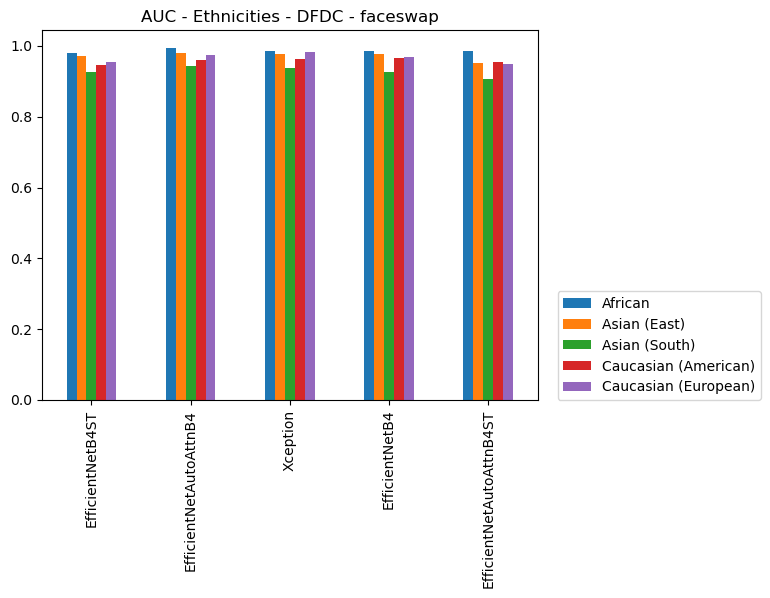

In [82]:
temp_df = ethnic_accuracy_df[ethnic_accuracy_df['training_dataset'] == 'DFDC']
af_auc = []
ca_auc = []
ce_auc = []
ae_auc = []
as_auc = []

model_names = [m.split('_')[0] for m in df_dict.keys()]
model_names = list(set(model_names))
for model in model_names:
    cond = (temp_df['model']==model) & (temp_df['ethnicity']=='African')
    af_auc.append(temp_df[cond]['auc-roc'].values[0])
    cond = (temp_df['model']==model) & (temp_df['ethnicity']=='Asian (East)')
    ae_auc.append(temp_df[cond]['auc-roc'].values[0])
    cond = (temp_df['model']==model) & (temp_df['ethnicity']=='Asian (South)')
    as_auc.append(temp_df[cond]['auc-roc'].values[0])
    cond = (temp_df['model']==model) & (temp_df['ethnicity']=='Caucasian (American)')
    ca_auc.append(temp_df[cond]['auc-roc'].values[0])
    cond = (temp_df['model']==model) & (temp_df['ethnicity']=='Caucasian (European)')
    ce_auc.append(temp_df[cond]['auc-roc'].values[0])
    
d_b = pd.DataFrame({
    'African':af_auc,
    'Asian (East)':ae_auc,
    'Asian (South)':as_auc,
    'Caucasian (American)':ca_auc,
    'Caucasian (European)':ce_auc,
})
d_b.index = model_names
d_b.plot.bar(title = 'AUC - Ethnicities - DFDC - faceswap')
plt.legend(loc=(1.04,0))
plt.show()

In [72]:
temp_df = ethnic_accuracy_df[ethnic_accuracy_df['training_dataset'] == 'DFDC']
cols_to_select = ['model','ethnicity','accuracy','auc-roc']
temp_dfs = []
model_names = [m.split('_')[0] for m in df_dict.keys()]
model_names = list(set(model_names))
for model in model_names:
    all_auc= temp_df[temp_df['model'] == model]['auc-roc'].values
    min_auc = min(all_auc)
    max_auc = max(all_auc)
    cond = (temp_df['auc-roc'] == min_auc) | (temp_df['auc-roc'] == max_auc)
    rows = temp_df[cond][cols_to_select].sort_values(by=['auc-roc'])
    temp_dfs.append(rows)
    
for df_ in temp_dfs:
    print(df_)

               model      ethnicity  accuracy   auc-roc
42  EfficientNetB4ST  Asian (South)  0.815000  0.927100
40  EfficientNetB4ST        African  0.851648  0.981098
                     model      ethnicity  accuracy  auc-roc
12  EfficientNetAutoAttnB4  Asian (South)  0.815000  0.94370
10  EfficientNetAutoAttnB4        African  0.835165  0.99439
       model      ethnicity  accuracy   auc-roc
22  Xception  Asian (South)  0.845000  0.938100
20  Xception        African  0.934066  0.984634
            model      ethnicity  accuracy   auc-roc
2  EfficientNetB4  Asian (South)  0.775000  0.925000
0  EfficientNetB4        African  0.791209  0.986585
                       model      ethnicity  accuracy   auc-roc
32  EfficientNetAutoAttnB4ST  Asian (South)  0.805000  0.907600
30  EfficientNetAutoAttnB4ST        African  0.868132  0.985732


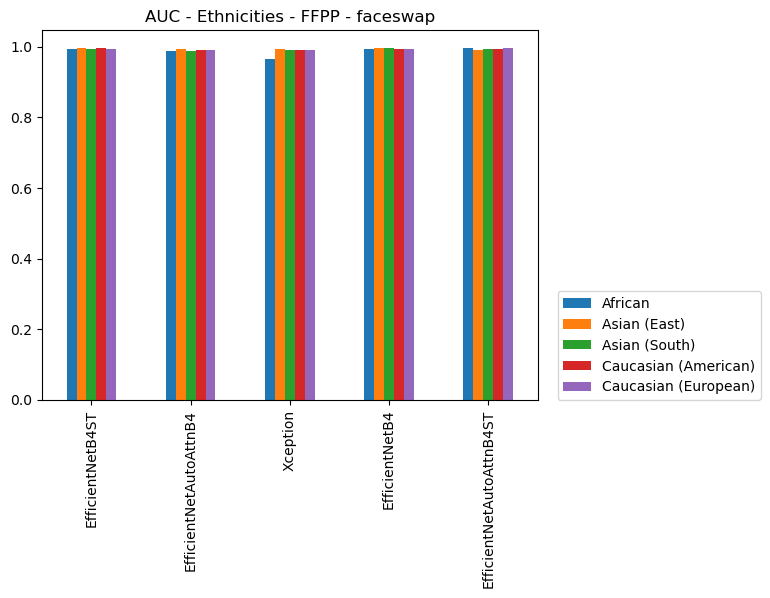

In [83]:
temp_df = ethnic_accuracy_df[ethnic_accuracy_df['training_dataset'] == 'FFPP']
af_auc = []
ca_auc = []
ce_auc = []
ae_auc = []
as_auc = []

model_names = [m.split('_')[0] for m in df_dict.keys()]
model_names = list(set(model_names))
for model in model_names:
    cond = (temp_df['model']==model) & (temp_df['ethnicity']=='African')
    af_auc.append(temp_df[cond]['auc-roc'].values[0])
    cond = (temp_df['model']==model) & (temp_df['ethnicity']=='Asian (East)')
    ae_auc.append(temp_df[cond]['auc-roc'].values[0])
    cond = (temp_df['model']==model) & (temp_df['ethnicity']=='Asian (South)')
    as_auc.append(temp_df[cond]['auc-roc'].values[0])
    cond = (temp_df['model']==model) & (temp_df['ethnicity']=='Caucasian (American)')
    ca_auc.append(temp_df[cond]['auc-roc'].values[0])
    cond = (temp_df['model']==model) & (temp_df['ethnicity']=='Caucasian (European)')
    ce_auc.append(temp_df[cond]['auc-roc'].values[0])
    
d_b = pd.DataFrame({
    'African':af_auc,
    'Asian (East)':ae_auc,
    'Asian (South)':as_auc,
    'Caucasian (American)':ca_auc,
    'Caucasian (European)':ce_auc,
})
d_b.index = model_names
d_b.plot.bar(title = 'AUC - Ethnicities - FFPP - faceswap')
plt.legend(loc=(1.04,0))
plt.show()

In [73]:
temp_df = ethnic_accuracy_df[ethnic_accuracy_df['training_dataset'] == 'FFPP']
cols_to_select = ['model','ethnicity','accuracy','auc-roc']
temp_dfs = []
model_names = [m.split('_')[0] for m in df_dict.keys()]
model_names = list(set(model_names))
for model in model_names:
    all_auc= temp_df[temp_df['model'] == model]['auc-roc'].values
    min_auc = min(all_auc)
    max_auc = max(all_auc)
    cond = (temp_df['auc-roc'] == min_auc) | (temp_df['auc-roc'] == max_auc)
    rows = temp_df[cond][cols_to_select].sort_values(by=['auc-roc'])
    temp_dfs.append(rows)
    
for df_ in temp_dfs:
    print(df_)

               model     ethnicity  accuracy   auc-roc
15  EfficientNetB4ST       African  0.961538  0.993171
16  EfficientNetB4ST  Asian (East)  0.900000  0.996000
                     model      ethnicity  accuracy   auc-roc
37  EfficientNetAutoAttnB4  Asian (South)  0.915000  0.987400
36  EfficientNetAutoAttnB4   Asian (East)  0.935294  0.994571
       model     ethnicity  accuracy   auc-roc
45  Xception       African  0.912088  0.964390
46  Xception  Asian (East)  0.929412  0.992857
            model             ethnicity  accuracy   auc-roc
8  EfficientNetB4  Caucasian (American)  0.948187  0.993548
7  EfficientNetB4         Asian (South)  0.970000  0.996600
                       model     ethnicity  accuracy   auc-roc
26  EfficientNetAutoAttnB4ST  Asian (East)  0.929412  0.990143
25  EfficientNetAutoAttnB4ST       African  0.950549  0.996463


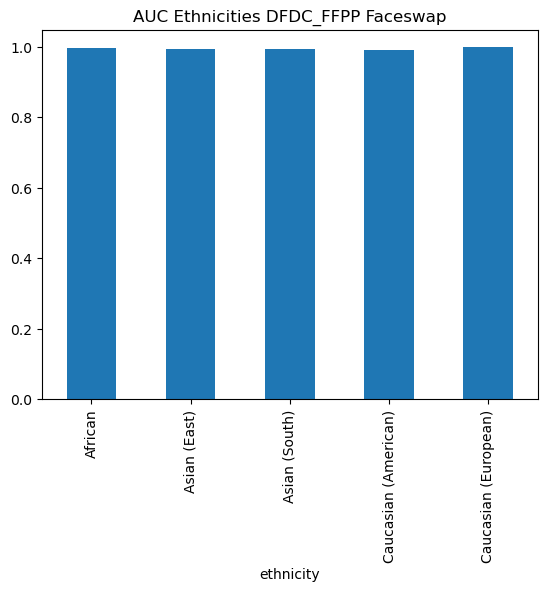

In [162]:
temp_df = ethnic_accuracy_df[ethnic_accuracy_df['training_dataset'] == 'DFDC_FFPP']
temp_df.plot.bar(x='ethnicity',y='auc-roc',title='AUC Ethnicities DFDC_FFPP Faceswap',legend=False)
plt.show()

#### Groups with low to high accuracy ( models trained on DFDC )

In [57]:
temp_df = ethnic_accuracy_df[ethnic_accuracy_df['training_dataset'] == 'DFDC']
temp_df.sort_values(by=['auc-roc'])

,model,training_dataset,ethnicity,accuracy,precision_0,precision_1,recall_0,recall_1,f1_0,f1_1,tpr,fpr,thresholds-roc,auc-roc
32,EfficientNetAutoAttnB4ST,DFDC,Asian (South),0.805000,0.867470,0.760684,0.72,0.890000,0.786885,0.820276,"[0.0, 0.01, 0.32, 0.32, 0.58, 0.58, 0.63, 0.63...","[0.0, 0.0, 0.0, 0.01, 0.01, 0.02, 0.02, 0.03, ...","[1.9768653999999999, 0.9768654, 0.9452732, 0.9...",0.907600
2,EfficientNetB4,DFDC,Asian (South),0.775000,0.898551,0.709924,0.62,0.930000,0.733728,0.805195,"[0.0, 0.01, 0.54, 0.54, 0.56, 0.56, 0.64, 0.64...","[0.0, 0.0, 0.0, 0.01, 0.01, 0.02, 0.02, 0.03, ...","[1.9998928299999998, 0.99989283, 0.9912219, 0....",0.925000
42,EfficientNetB4ST,DFDC,Asian (South),0.815000,0.898734,0.760331,0.71,0.920000,0.793296,0.832579,"[0.0, 0.01, 0.51, 0.51, 0.52, 0.52, 0.65, 0.65...","[0.0, 0.0, 0.0, 0.01, 0.01, 0.02, 0.02, 0.03, ...","[1.9873392600000002, 0.98733926, 0.9362766, 0....",0.927100
22,Xception,DFDC,Asian (South),0.845000,0.863158,0.828571,0.82,0.870000,0.841026,0.848780,"[0.0, 0.01, 0.48, 0.48, 0.51, 0.51, 0.69, 0.69...","[0.0, 0.0, 0.0, 0.01, 0.01, 0.02, 0.02, 0.03, ...","[1.9989998, 0.9989998, 0.97955143, 0.9769816, ...",0.938100
12,EfficientNetAutoAttnB4,DFDC,Asian (South),0.815000,0.909091,0.756098,0.70,0.930000,0.790960,0.834081,"[0.0, 0.01, 0.5, 0.5, 0.68, 0.68, 0.7, 0.7, 0....","[0.0, 0.0, 0.0, 0.01, 0.01, 0.02, 0.02, 0.04, ...","[1.9997342, 0.9997342, 0.9871272, 0.9869153, 0...",0.943700
43,EfficientNetB4ST,DFDC,Caucasian (American),0.860104,0.950617,0.794643,0.77,0.956989,0.850829,0.868293,"[0.0, 0.010752688172043012, 0.5376344086021505...","[0.0, 0.0, 0.0, 0.01, 0.01, 0.02, 0.02, 0.03, ...","[1.97870684, 0.97870684, 0.914207, 0.9057066, ...",0.944731
34,EfficientNetAutoAttnB4ST,DFDC,Caucasian (European),0.837563,0.935897,0.773109,0.73,0.948454,0.820225,0.851852,"[0.0, 0.0, 0.4639175257731959, 0.4639175257731...","[0.0, 0.01, 0.01, 0.02, 0.02, 0.03, 0.03, 0.04...","[1.9757229, 0.9757229, 0.94672996, 0.9451632, ...",0.949278
31,EfficientNetAutoAttnB4ST,DFDC,Asian (East),0.800000,0.985294,0.676471,0.67,0.985714,0.797619,0.802326,"[0.0, 0.014285714285714285, 0.4142857142857143...","[0.0, 0.0, 0.0, 0.01, 0.01, 0.02, 0.02, 0.03, ...","[1.97796327, 0.97796327, 0.9399989, 0.9397842,...",0.951714
33,EfficientNetAutoAttnB4ST,DFDC,Caucasian (American),0.808290,0.931507,0.733333,0.68,0.946237,0.786127,0.826291,"[0.0, 0.010752688172043012, 0.5591397849462365...","[0.0, 0.0, 0.0, 0.01, 0.01, 0.02, 0.02, 0.03, ...","[1.9771249, 0.9771249, 0.93540686, 0.9340442, ...",0.955054
44,EfficientNetB4ST,DFDC,Caucasian (European),0.862944,0.962025,0.796610,0.76,0.969072,0.849162,0.874419,"[0.0, 0.010309278350515464, 0.4742268041237113...","[0.0, 0.0, 0.0, 0.01, 0.01, 0.02, 0.02, 0.03, ...","[1.983206, 0.983206, 0.9418315, 0.94048065, 0....",0.955670


#### Groups with low to high accuracy ( models trained on FFPP)

In [58]:
temp_df = ethnic_accuracy_df[ethnic_accuracy_df['training_dataset'] == 'FFPP']
temp_df.sort_values(by=['auc-roc'])

,model,training_dataset,ethnicity,accuracy,precision_0,precision_1,recall_0,recall_1,f1_0,f1_1,tpr,fpr,thresholds-roc,auc-roc
45,Xception,FFPP,African,0.912088,0.903846,0.923077,0.94,0.878049,0.921569,0.900000,"[0.0, 0.012195121951219513, 0.6951219512195121...","[0.0, 0.0, 0.0, 0.01, 0.01, 0.02, 0.02, 0.03, ...","[1.99336445, 0.99336445, 0.8280864, 0.7977816,...",0.964390
37,EfficientNetAutoAttnB4,FFPP,Asian (South),0.915000,0.919192,0.910891,0.91,0.920000,0.914573,0.915423,"[0.0, 0.01, 0.71, 0.71, 0.85, 0.85, 0.89, 0.89...","[0.0, 0.0, 0.0, 0.01, 0.01, 0.02, 0.02, 0.03, ...","[1.99919087, 0.99919087, 0.8547093, 0.8456384,...",0.987400
35,EfficientNetAutoAttnB4,FFPP,African,0.961538,0.951456,0.974684,0.98,0.939024,0.965517,0.956522,"[0.0, 0.012195121951219513, 0.6219512195121951...","[0.0, 0.0, 0.0, 0.01, 0.01, 0.02, 0.02, 0.04, ...","[1.9977853300000001, 0.99778533, 0.83069927, 0...",0.989146
39,EfficientNetAutoAttnB4,FFPP,Caucasian (European),0.954315,0.959596,0.948980,0.95,0.958763,0.954774,0.953846,"[0.0, 0.010309278350515464, 0.5567010309278351...","[0.0, 0.0, 0.0, 0.01, 0.01, 0.02, 0.02, 0.04, ...","[1.99901843, 0.99901843, 0.96251744, 0.9613452...",0.989588
48,Xception,FFPP,Caucasian (American),0.963731,0.969697,0.957447,0.96,0.967742,0.964824,0.962567,"[0.0, 0.010752688172043012, 0.9032258064516129...","[0.0, 0.0, 0.0, 0.01, 0.01, 0.02, 0.02, 0.03, ...","[1.9976878, 0.9976878, 0.77894914, 0.77811664,...",0.989677
26,EfficientNetAutoAttnB4ST,FFPP,Asian (East),0.929412,0.988889,0.862500,0.89,0.985714,0.936842,0.920000,"[0.0, 0.014285714285714285, 0.8, 0.8, 0.842857...","[0.0, 0.0, 0.0, 0.01, 0.01, 0.02, 0.02, 0.03, ...","[1.9742244, 0.9742244, 0.81074506, 0.81034005,...",0.990143
49,Xception,FFPP,Caucasian (European),0.939086,0.948980,0.929293,0.93,0.948454,0.939394,0.938776,"[0.0, 0.010309278350515464, 0.8762886597938144...","[0.0, 0.0, 0.0, 0.01, 0.01, 0.03, 0.03, 0.05, ...","[1.9983092500000001, 0.99830925, 0.82263416, 0...",0.990206
47,Xception,FFPP,Asian (South),0.950000,0.989130,0.916667,0.91,0.990000,0.947917,0.951923,"[0.0, 0.01, 0.62, 0.62, 0.92, 0.92, 0.93, 0.93...","[0.0, 0.0, 0.0, 0.01, 0.01, 0.04, 0.04, 0.07, ...","[1.99834526, 0.99834526, 0.95068556, 0.9486518...",0.990800
38,EfficientNetAutoAttnB4,FFPP,Caucasian (American),0.963731,0.979381,0.947917,0.95,0.978495,0.964467,0.962963,"[0.0, 0.010752688172043012, 0.8602150537634409...","[0.0, 0.0, 0.0, 0.01, 0.01, 0.03, 0.03, 0.04, ...","[1.9991105, 0.9991105, 0.74636334, 0.7445732, ...",0.991828
46,Xception,FFPP,Asian (East),0.929412,0.988889,0.862500,0.89,0.985714,0.936842,0.920000,"[0.0, 0.014285714285714285, 0.8, 0.8, 0.942857...","[0.0, 0.0, 0.0, 0.02, 0.02, 0.05, 0.05, 0.07, ...","[1.99642473, 0.99642473, 0.8977867, 0.8963505,...",0.992857


#### Groups with low to high accuracy ( models trained on both DFDC and FFPP)

In [141]:
temp_df = ethnic_accuracy_df[ethnic_accuracy_df['training_dataset'] == 'DFDC_FFPP']
temp_df.sort_values(by=['auc-roc'])

,model,training_dataset,ethnicity,accuracy,precision_0,precision_1,recall_0,recall_1,f1_0,f1_1,tpr,fpr,thresholds-roc,auc-roc
53,CrossEffViT,DFDC_FFPP,Caucasian (American),0.963731,0.989474,0.938776,0.94,0.989247,0.964103,0.963351,"[0.0, 0.010752688172043012, 0.7956989247311828...","[0.0, 0.0, 0.0, 0.01, 0.01, 0.02, 0.02, 0.03, ...","[1.9999582, 0.9999582, 0.96362114, 0.9606824, ...",0.991398
52,CrossEffViT,DFDC_FFPP,Asian (South),0.945000,0.978495,0.915888,0.91,0.980000,0.943005,0.946860,"[0.0, 0.01, 0.89, 0.89, 0.95, 0.95, 0.96, 0.96...","[0.0, 0.0, 0.0, 0.01, 0.01, 0.02, 0.02, 0.08, ...","[1.99995923, 0.99995923, 0.9600475, 0.952275, ...",0.994900
51,CrossEffViT,DFDC_FFPP,Asian (East),0.923529,1.000000,0.843373,0.87,1.000000,0.930481,0.915033,"[0.0, 0.014285714285714285, 0.6857142857142857...","[0.0, 0.0, 0.0, 0.01, 0.01, 0.02, 0.02, 0.03, ...","[1.9999617, 0.9999617, 0.9969868, 0.99694365, ...",0.995143
50,CrossEffViT,DFDC_FFPP,African,0.928571,1.000000,0.863158,0.87,1.000000,0.930481,0.926554,"[0.0, 0.012195121951219513, 0.0731707317073170...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.01, 0.01, 0.02, 0....","[1.99995816, 0.99995816, 0.99995464, 0.9999521...",0.996098
54,CrossEffViT,DFDC_FFPP,Caucasian (European),0.959391,1.000000,0.923810,0.92,1.000000,0.958333,0.960396,"[0.0, 0.010309278350515464, 0.0515463917525773...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.02, 0.02, 0.03, 0....","[1.9999637, 0.9999637, 0.9999582, 0.9999577, 0...",0.998247


## Gender Group

In [173]:
accs = []
datasets = []
genders = []
model_names = []
precision_0 = []
precision_1 = []
recall_0 = []
recall_1 = []
f1_0 = []
f1_1 = []
tpr = []
fpr = []
thresholds_roc=[]
auc_roc = []

for model_name,df in df_dict.items():
    
    for gender in GENDERS:
        acc,stats_dict = get_accuracy_scores_gender(df,gender)
        accs.append(acc)
        genders.append(gender)
        precision_0.append(stats_dict['precision_0'])
        precision_1.append(stats_dict['precision_1'])
        recall_0.append(stats_dict['recall_0'])
        recall_1.append(stats_dict['recall_1'])
        f1_0.append(stats_dict['f1_0'])
        f1_1.append(stats_dict['f1_1'])
        tpr.append(stats_dict['tpr'])
        fpr.append(stats_dict['fpr'])
        thresholds_roc.append(stats_dict['thresholds-roc'])
        auc_roc.append(stats_dict['auc-roc'])

        if model_name.startswith('CrossEff'):
            datasets.append('DFDC_FFPP')
            model_names.append('CrossEffViT')
        else:
            datasets.append(model_name.split('_')[-1])
            model_names.append(model_name.split('_')[0])


gender_accuracy_df = pd.DataFrame({
    'model': model_names,
    'training_dataset':datasets,
    'gender': genders,
    'accuracy': accs,
    'precision_0' : precision_0,
    'precision_1' : precision_1,
    'recall_0' : recall_0,
    'recall_1' : recall_1,
    'f1_0': f1_0,
    'f1_1' : f1_1,
    'tpr': tpr,
    'fpr': fpr,
    'thresholds-roc': thresholds_roc,
    'auc-roc':auc_roc
})

gender_accuracy_df.sort_values(by=['auc-roc'])

,model,training_dataset,gender,accuracy,precision_0,precision_1,recall_0,recall_1,f1_0,f1_1,tpr,fpr,thresholds-roc,auc-roc
17,EfficientNetB4ST,DFDC,women,0.876068,0.928571,0.827869,0.832,0.926606,0.877637,0.874459,"[0.0, 0.0045871559633027525, 0.385321100917431...","[0.0, 0.0, 0.0, 0.004, 0.004, 0.008, 0.008, 0....","[1.97755253, 0.97755253, 0.9418315, 0.94048065...",0.952037
13,EfficientNetAutoAttnB4ST,DFDC,women,0.876068,0.913793,0.838983,0.848,0.908257,0.879668,0.872247,"[0.0, 0.0045871559633027525, 0.568807339449541...","[0.0, 0.0, 0.0, 0.004, 0.004, 0.008, 0.008, 0....","[1.9771249, 0.9771249, 0.91908103, 0.91895264,...",0.953046
1,EfficientNetB4,DFDC,women,0.844017,0.953846,0.765568,0.744,0.958716,0.835955,0.851324,"[0.0, 0.0045871559633027525, 0.454128440366972...","[0.0, 0.0, 0.0, 0.004, 0.004, 0.008, 0.008, 0....","[1.99943787, 0.99943787, 0.99162453, 0.9913204...",0.954073
12,EfficientNetAutoAttnB4ST,DFDC,men,0.772152,0.986301,0.676829,0.576,0.991071,0.727273,0.804348,"[0.0, 0.004464285714285714, 0.0089285714285714...","[0.0, 0.0, 0.0, 0.004, 0.004, 0.012, 0.012, 0....","[1.97796327, 0.97796327, 0.97631615, 0.9757229...",0.959304
5,EfficientNetAutoAttnB4,DFDC,women,0.839744,0.948718,0.761905,0.740,0.954128,0.831461,0.847251,"[0.0, 0.0045871559633027525, 0.513761467889908...","[0.0, 0.0, 0.0, 0.004, 0.004, 0.008, 0.008, 0....","[1.9994996999999999, 0.9994997, 0.9871272, 0.9...",0.963119
9,Xception,DFDC,women,0.901709,0.918033,0.883929,0.896,0.908257,0.906883,0.895928,"[0.0, 0.0045871559633027525, 0.403669724770642...","[0.0, 0.0, 0.0, 0.004, 0.004, 0.008, 0.008, 0....","[1.9993650299999999, 0.99936503, 0.9824989, 0....",0.963670
16,EfficientNetB4ST,DFDC,men,0.814346,0.993902,0.719355,0.652,0.995536,0.787440,0.835206,"[0.0, 0.004464285714285714, 0.2633928571428571...","[0.0, 0.0, 0.0, 0.004, 0.004, 0.008, 0.008, 0....","[1.9873392600000002, 0.98733926, 0.9652713, 0....",0.969982
4,EfficientNetAutoAttnB4,DFDC,men,0.831224,0.994186,0.738411,0.684,0.995536,0.810427,0.847909,"[0.0, 0.004464285714285714, 0.5758928571428571...","[0.0, 0.0, 0.0, 0.004, 0.004, 0.008, 0.008, 0....","[1.9997342, 0.9997342, 0.98762256, 0.9869398, ...",0.976018
18,Xception,FFPP,men,0.930380,0.932271,0.928251,0.936,0.924107,0.934132,0.926174,"[0.0, 0.004464285714285714, 0.5982142857142857...","[0.0, 0.0, 0.0, 0.008, 0.008, 0.012, 0.012, 0....","[1.9980977, 0.9980977, 0.8980037, 0.8963505, 0...",0.976625
8,Xception,DFDC,men,0.915612,0.968750,0.868000,0.868,0.968750,0.915612,0.915612,"[0.0, 0.004464285714285714, 0.3973214285714285...","[0.0, 0.0, 0.0, 0.004, 0.004, 0.008, 0.008, 0....","[1.99915373, 0.99915373, 0.9892301, 0.98833966...",0.976982


In [174]:
cols_to_use = ['model',	'gender','training_dataset',	'accuracy',	'precision_0','precision_1','recall_0',	'recall_1','f1_0', 'f1_1','auc-roc']
gender_accuracy_df = gender_accuracy_df.round(decimals=2)
gender_accuracy_df[cols_to_use].to_csv('./tables/gender/faceswap.csv',index=False)

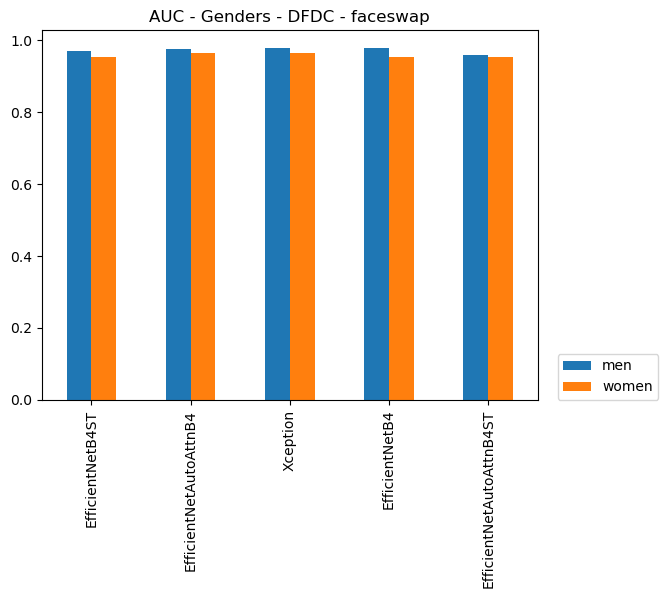

In [86]:
temp_df = gender_accuracy_df[gender_accuracy_df['training_dataset'] == 'DFDC']
m_auc = []
w_auc = []

model_names = [m.split('_')[0] for m in df_dict.keys()]
model_names = list(set(model_names))
for model in model_names:
    cond = (temp_df['model']==model) & (temp_df['gender']=='men')
    m_auc.append(temp_df[cond]['auc-roc'].values[0])
    cond = (temp_df['model']==model) & (temp_df['gender']=='women')
    w_auc.append(temp_df[cond]['auc-roc'].values[0])
    
    
d_b = pd.DataFrame({
    'men':m_auc,
    'women':w_auc
})
d_b.index = model_names
d_b.plot.bar(title = 'AUC - Genders - DFDC - faceswap')
plt.legend(loc=(1.04,0))
plt.show()

In [74]:
temp_df = gender_accuracy_df[gender_accuracy_df['training_dataset'] == 'DFDC']
cols_to_select = ['model','gender','accuracy','auc-roc']
temp_dfs = []
model_names = [m.split('_')[0] for m in df_dict.keys()]
model_names = list(set(model_names))
for model in model_names:
    all_auc= temp_df[temp_df['model'] == model]['auc-roc'].values
    min_auc = min(all_auc)
    max_auc = max(all_auc)
    cond = (temp_df['auc-roc'] == min_auc) | (temp_df['auc-roc'] == max_auc)
    rows = temp_df[cond][cols_to_select].sort_values(by=['auc-roc'])
    temp_dfs.append(rows)
    
for df_ in temp_dfs:
    print(df_)

               model gender  accuracy   auc-roc
17  EfficientNetB4ST  women  0.876068  0.952037
16  EfficientNetB4ST    men  0.814346  0.969982
                    model gender  accuracy   auc-roc
5  EfficientNetAutoAttnB4  women  0.839744  0.963119
4  EfficientNetAutoAttnB4    men  0.831224  0.976018
      model gender  accuracy   auc-roc
9  Xception  women  0.901709  0.963670
8  Xception    men  0.915612  0.976982
            model gender  accuracy   auc-roc
1  EfficientNetB4  women  0.844017  0.954073
0  EfficientNetB4    men  0.748945  0.978286
                       model gender  accuracy   auc-roc
13  EfficientNetAutoAttnB4ST  women  0.876068  0.953046
12  EfficientNetAutoAttnB4ST    men  0.772152  0.959304


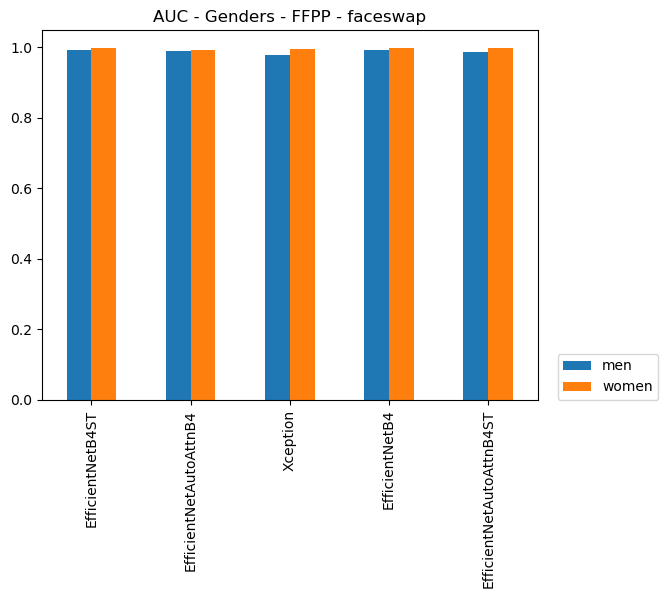

In [87]:
temp_df = gender_accuracy_df[gender_accuracy_df['training_dataset'] == 'FFPP']
m_auc = []
w_auc = []

model_names = [m.split('_')[0] for m in df_dict.keys()]
model_names = list(set(model_names))
for model in model_names:
    cond = (temp_df['model']==model) & (temp_df['gender']=='men')
    m_auc.append(temp_df[cond]['auc-roc'].values[0])
    cond = (temp_df['model']==model) & (temp_df['gender']=='women')
    w_auc.append(temp_df[cond]['auc-roc'].values[0])
    
    
d_b = pd.DataFrame({
    'men':m_auc,
    'women':w_auc
})
d_b.index = model_names
d_b.plot.bar(title = 'AUC - Genders - FFPP - faceswap')
plt.legend(loc=(1.04,0))
plt.show()

In [75]:
temp_df = gender_accuracy_df[gender_accuracy_df['training_dataset'] == 'FFPP']
cols_to_select = ['model','gender','accuracy','auc-roc']
temp_dfs = []
model_names = [m.split('_')[0] for m in df_dict.keys()]
model_names = list(set(model_names))
for model in model_names:
    all_auc= temp_df[temp_df['model'] == model]['auc-roc'].values
    min_auc = min(all_auc)
    max_auc = max(all_auc)
    cond = (temp_df['auc-roc'] == min_auc) | (temp_df['auc-roc'] == max_auc)
    rows = temp_df[cond][cols_to_select].sort_values(by=['auc-roc'])
    temp_dfs.append(rows)
    
for df_ in temp_dfs:
    print(df_)

              model gender  accuracy   auc-roc
6  EfficientNetB4ST    men  0.936709  0.991089
7  EfficientNetB4ST  women  0.948718  0.995780
                     model gender  accuracy   auc-roc
14  EfficientNetAutoAttnB4    men  0.949367  0.988339
15  EfficientNetAutoAttnB4  women  0.942308  0.991266
       model gender  accuracy   auc-roc
18  Xception    men  0.930380  0.976625
19  Xception  women  0.948718  0.994092
            model gender  accuracy   auc-roc
2  EfficientNetB4    men  0.945148  0.990768
3  EfficientNetB4  women  0.957265  0.997450
                       model gender  accuracy   auc-roc
10  EfficientNetAutoAttnB4ST    men  0.934599  0.986911
11  EfficientNetAutoAttnB4ST  women  0.965812  0.997064


<AxesSubplot:title={'center':'AUC Gender DFDC_FFPP Faceswap'}, xlabel='gender'>

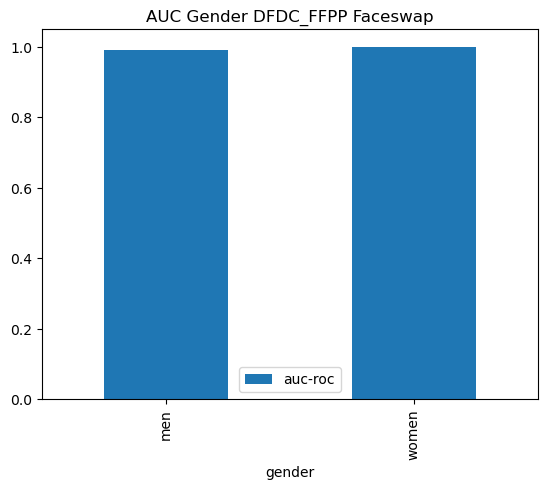

In [150]:
temp_df = gender_accuracy_df[gender_accuracy_df['training_dataset'] == 'DFDC_FFPP']
temp_df.plot.bar(x='gender',y='auc-roc',title='AUC Gender DFDC_FFPP Faceswap')

#### Groups with low to high accuracy ( models trained on DFDC )

In [61]:
temp_df = gender_accuracy_df[gender_accuracy_df['training_dataset'] == 'DFDC']
temp_df.sort_values(by=['auc-roc'])

,model,training_dataset,gender,accuracy,precision_0,precision_1,recall_0,recall_1,f1_0,f1_1,tpr,fpr,thresholds-roc,auc-roc
17,EfficientNetB4ST,DFDC,women,0.876068,0.928571,0.827869,0.832,0.926606,0.877637,0.874459,"[0.0, 0.0045871559633027525, 0.385321100917431...","[0.0, 0.0, 0.0, 0.004, 0.004, 0.008, 0.008, 0....","[1.97755253, 0.97755253, 0.9418315, 0.94048065...",0.952037
13,EfficientNetAutoAttnB4ST,DFDC,women,0.876068,0.913793,0.838983,0.848,0.908257,0.879668,0.872247,"[0.0, 0.0045871559633027525, 0.568807339449541...","[0.0, 0.0, 0.0, 0.004, 0.004, 0.008, 0.008, 0....","[1.9771249, 0.9771249, 0.91908103, 0.91895264,...",0.953046
1,EfficientNetB4,DFDC,women,0.844017,0.953846,0.765568,0.744,0.958716,0.835955,0.851324,"[0.0, 0.0045871559633027525, 0.454128440366972...","[0.0, 0.0, 0.0, 0.004, 0.004, 0.008, 0.008, 0....","[1.99943787, 0.99943787, 0.99162453, 0.9913204...",0.954073
12,EfficientNetAutoAttnB4ST,DFDC,men,0.772152,0.986301,0.676829,0.576,0.991071,0.727273,0.804348,"[0.0, 0.004464285714285714, 0.0089285714285714...","[0.0, 0.0, 0.0, 0.004, 0.004, 0.012, 0.012, 0....","[1.97796327, 0.97796327, 0.97631615, 0.9757229...",0.959304
5,EfficientNetAutoAttnB4,DFDC,women,0.839744,0.948718,0.761905,0.740,0.954128,0.831461,0.847251,"[0.0, 0.0045871559633027525, 0.513761467889908...","[0.0, 0.0, 0.0, 0.004, 0.004, 0.008, 0.008, 0....","[1.9994996999999999, 0.9994997, 0.9871272, 0.9...",0.963119
9,Xception,DFDC,women,0.901709,0.918033,0.883929,0.896,0.908257,0.906883,0.895928,"[0.0, 0.0045871559633027525, 0.403669724770642...","[0.0, 0.0, 0.0, 0.004, 0.004, 0.008, 0.008, 0....","[1.9993650299999999, 0.99936503, 0.9824989, 0....",0.963670
16,EfficientNetB4ST,DFDC,men,0.814346,0.993902,0.719355,0.652,0.995536,0.787440,0.835206,"[0.0, 0.004464285714285714, 0.2633928571428571...","[0.0, 0.0, 0.0, 0.004, 0.004, 0.008, 0.008, 0....","[1.9873392600000002, 0.98733926, 0.9652713, 0....",0.969982
4,EfficientNetAutoAttnB4,DFDC,men,0.831224,0.994186,0.738411,0.684,0.995536,0.810427,0.847909,"[0.0, 0.004464285714285714, 0.5758928571428571...","[0.0, 0.0, 0.0, 0.004, 0.004, 0.008, 0.008, 0....","[1.9997342, 0.9997342, 0.98762256, 0.9869398, ...",0.976018
8,Xception,DFDC,men,0.915612,0.968750,0.868000,0.868,0.968750,0.915612,0.915612,"[0.0, 0.004464285714285714, 0.3973214285714285...","[0.0, 0.0, 0.0, 0.004, 0.004, 0.008, 0.008, 0....","[1.99915373, 0.99915373, 0.9892301, 0.98833966...",0.976982
0,EfficientNetB4,DFDC,men,0.748945,0.985185,0.654867,0.532,0.991071,0.690909,0.788632,"[0.0, 0.004464285714285714, 0.5848214285714286...","[0.0, 0.0, 0.0, 0.004, 0.004, 0.008, 0.008, 0....","[1.9998928299999998, 0.99989283, 0.990507, 0.9...",0.978286


#### Groups with low to high accuracy ( models trained on FFPP )

In [62]:
temp_df = gender_accuracy_df[gender_accuracy_df['training_dataset'] == 'FFPP']
temp_df.sort_values(by=['auc-roc'])

,model,training_dataset,gender,accuracy,precision_0,precision_1,recall_0,recall_1,f1_0,f1_1,tpr,fpr,thresholds-roc,auc-roc
18,Xception,FFPP,men,0.930380,0.932271,0.928251,0.936,0.924107,0.934132,0.926174,"[0.0, 0.004464285714285714, 0.5982142857142857...","[0.0, 0.0, 0.0, 0.008, 0.008, 0.012, 0.012, 0....","[1.9980977, 0.9980977, 0.8980037, 0.8963505, 0...",0.976625
10,EfficientNetAutoAttnB4ST,FFPP,men,0.934599,0.929412,0.940639,0.948,0.919643,0.938614,0.930023,"[0.0, 0.004464285714285714, 0.6607142857142857...","[0.0, 0.0, 0.0, 0.004, 0.004, 0.008, 0.008, 0....","[1.97435546, 0.97435546, 0.8107182, 0.81034005...",0.986911
14,EfficientNetAutoAttnB4,FFPP,men,0.949367,0.948413,0.950450,0.956,0.941964,0.952191,0.946188,"[0.0, 0.004464285714285714, 0.7142857142857143...","[0.0, 0.0, 0.0, 0.004, 0.004, 0.008, 0.008, 0....","[1.99901843, 0.99901843, 0.835784, 0.8351553, ...",0.988339
2,EfficientNetB4,FFPP,men,0.945148,0.978632,0.912500,0.916,0.977679,0.946281,0.943966,"[0.0, 0.004464285714285714, 0.6026785714285714...","[0.0, 0.0, 0.0, 0.004, 0.004, 0.008, 0.008, 0....","[1.9993436, 0.9993436, 0.9436163, 0.9435221, 0...",0.990768
6,EfficientNetB4ST,FFPP,men,0.936709,0.970085,0.904167,0.908,0.968750,0.938017,0.935345,"[0.0, 0.004464285714285714, 0.8035714285714286...","[0.0, 0.0, 0.0, 0.004, 0.004, 0.008, 0.008, 0....","[1.99800855, 0.99800855, 0.8714834, 0.8694447,...",0.991089
15,EfficientNetAutoAttnB4,FFPP,women,0.942308,0.974468,0.909871,0.916,0.972477,0.944330,0.940133,"[0.0, 0.0045871559633027525, 0.564220183486238...","[0.0, 0.0, 0.0, 0.004, 0.004, 0.008, 0.008, 0....","[1.99919087, 0.99919087, 0.96251744, 0.9613452...",0.991266
19,Xception,FFPP,women,0.948718,0.987069,0.911017,0.916,0.986239,0.950207,0.947137,"[0.0, 0.0045871559633027525, 0.665137614678899...","[0.0, 0.0, 0.0, 0.004, 0.004, 0.024, 0.024, 0....","[1.99834526, 0.99834526, 0.9487316, 0.9486518,...",0.994092
7,EfficientNetB4ST,FFPP,women,0.948718,0.987069,0.911017,0.916,0.986239,0.950207,0.947137,"[0.0, 0.0045871559633027525, 0.871559633027522...","[0.0, 0.0, 0.0, 0.004, 0.004, 0.008, 0.008, 0....","[1.99911076, 0.99911076, 0.8443534, 0.83802176...",0.995780
11,EfficientNetAutoAttnB4ST,FFPP,women,0.965812,0.979508,0.950893,0.956,0.977064,0.967611,0.963801,"[0.0, 0.0045871559633027525, 0.889908256880733...","[0.0, 0.0, 0.0, 0.004, 0.004, 0.008, 0.008, 0....","[1.98407966, 0.98407966, 0.72206503, 0.7080496...",0.997064
3,EfficientNetB4,FFPP,women,0.957265,0.991453,0.923077,0.928,0.990826,0.958678,0.955752,"[0.0, 0.0045871559633027525, 0.830275229357798...","[0.0, 0.0, 0.0, 0.004, 0.004, 0.012, 0.012, 0....","[1.9997248, 0.9997248, 0.9288709, 0.92870474, ...",0.997450


#### Groups with low to high accuracy ( models trained on both DFDC and FFPP )

In [164]:
temp_df = gender_accuracy_df[gender_accuracy_df['training_dataset'] == 'DFDC_FFPP']
temp_df.sort_values(by=['auc-roc'])

,model,training_dataset,gender,accuracy,precision_0,precision_1,recall_0,recall_1,f1_0,f1_1,tpr,fpr,thresholds-roc,auc-roc
20,CrossEffViT,DFDC_FFPP,men,0.932489,0.986607,0.884000,0.884,0.986607,0.932489,0.932489,"[0.0, 0.004464285714285714, 0.1160714285714285...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.004, 0.0...","[1.9999637, 0.9999637, 0.99995124, 0.9999509, ...",0.990036
21,CrossEffViT,DFDC_FFPP,women,0.957265,1.000000,0.915966,0.920,1.000000,0.958333,0.956140,"[0.0, 0.0045871559633027525, 0.013761467889908...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[1.9999617, 0.9999617, 0.9999584, 0.9999582, 0...",0.998716


## Ethnic and Gender Group

In [165]:
accs = []
datasets = []
genders = []
ethnics = []
model_names = []
precision_0 = []
precision_1 = []
recall_0 = []
recall_1 = []
f1_0 = []
f1_1 = []
tpr = []
fpr = []
thresholds_roc=[]
auc_roc = []

for model_name,df in df_dict.items():
    
    for gender in GENDERS:
        
        for eth in ETHNICITIES:
            acc,stats_dict = get_accuracy_scores_ethnicity_gender(df,eth,gender)
            accs.append(acc)
            genders.append(gender)
            ethnics.append(eth)
            precision_0.append(stats_dict['precision_0'])
            precision_1.append(stats_dict['precision_1'])
            recall_0.append(stats_dict['recall_0'])
            recall_1.append(stats_dict['recall_1'])
            f1_0.append(stats_dict['f1_0'])
            f1_1.append(stats_dict['f1_1'])
            tpr.append(stats_dict['tpr'])
            fpr.append(stats_dict['fpr'])
            thresholds_roc.append(stats_dict['thresholds-roc'])
            auc_roc.append(stats_dict['auc-roc'])

            if model_name.startswith('CrossEff'):
                datasets.append('DFDC_FFPP')
                model_names.append('CrossEffViT')
            else:
                datasets.append(model_name.split('_')[-1])
                model_names.append(model_name.split('_')[0])


gender_eth_accuracy_df = pd.DataFrame({
    'model': model_names,
    'training_dataset':datasets,
    'gender': genders,
    'ethnicity':ethnics,
    'accuracy': accs,
    'precision_0' : precision_0,
    'precision_1' : precision_1,
    'recall_0' : recall_0,
    'recall_1' : recall_1,
    'f1_0': f1_0,
    'f1_1' : f1_1,
    'tpr': tpr,
    'fpr': fpr,
    'thresholds-roc': thresholds_roc,
    'auc-roc':auc_roc
})

gender_eth_accuracy_df.sort_values(by=['auc-roc'])

,model,training_dataset,gender,ethnicity,accuracy,precision_0,precision_1,recall_0,recall_1,f1_0,f1_1,tpr,fpr,thresholds-roc,auc-roc
47,Xception,DFDC,women,Asian (South),0.770000,0.775510,0.764706,0.76,0.78,0.767677,0.772277,"[0.0, 0.02, 0.36, 0.36, 0.42, 0.42, 0.6, 0.6, ...","[0.0, 0.0, 0.0, 0.02, 0.02, 0.04, 0.04, 0.06, ...","[1.9989504999999999, 0.9989505, 0.97955143, 0....",0.8880
67,EfficientNetAutoAttnB4ST,DFDC,women,Asian (South),0.840000,0.814815,0.869565,0.88,0.80,0.846154,0.833333,"[0.0, 0.02, 0.52, 0.52, 0.7, 0.7, 0.76, 0.76, ...","[0.0, 0.0, 0.0, 0.02, 0.02, 0.04, 0.04, 0.06, ...","[1.9768653999999999, 0.9768654, 0.91205496, 0....",0.8968
7,EfficientNetB4,DFDC,women,Asian (South),0.840000,0.869565,0.814815,0.80,0.88,0.833333,0.846154,"[0.0, 0.02, 0.38, 0.38, 0.46, 0.46, 0.58, 0.58...","[0.0, 0.0, 0.0, 0.02, 0.02, 0.08, 0.08, 0.1, 0...","[1.9993001000000001, 0.9993001, 0.9912219, 0.9...",0.9052
87,EfficientNetB4ST,DFDC,women,Asian (South),0.820000,0.833333,0.807692,0.80,0.84,0.816327,0.823529,"[0.0, 0.02, 0.34, 0.34, 0.6, 0.6, 0.68, 0.68, ...","[0.0, 0.0, 0.0, 0.02, 0.02, 0.04, 0.04, 0.1, 0...","[1.97755253, 0.97755253, 0.9432201, 0.930991, ...",0.9108
27,EfficientNetAutoAttnB4,DFDC,women,Asian (South),0.820000,0.847826,0.796296,0.78,0.86,0.812500,0.826923,"[0.0, 0.02, 0.38, 0.38, 0.58, 0.58, 0.7, 0.7, ...","[0.0, 0.0, 0.0, 0.02, 0.02, 0.04, 0.04, 0.06, ...","[1.9992391, 0.9992391, 0.9871272, 0.9869153, 0...",0.9256
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15,EfficientNetB4,FFPP,women,African,0.954545,1.000000,0.904762,0.92,1.00,0.958333,0.950000,"[0.0, 0.02631578947368421, 1.0, 1.0]","[0.0, 0.0, 0.0, 1.0]","[1.99911076, 0.99911076, 0.677279, 0.0029024954]",1.0000
38,EfficientNetB4ST,FFPP,women,Caucasian (American),0.956989,1.000000,0.914894,0.92,1.00,0.958333,0.955556,"[0.0, 0.023255813953488372, 1.0, 1.0]","[0.0, 0.0, 0.0, 1.0]","[1.9857401000000001, 0.9857401, 0.80042344, 0....",1.0000
108,CrossEffViT,DFDC_FFPP,women,Caucasian (American),0.989247,1.000000,0.977273,0.98,1.00,0.989899,0.988506,"[0.0, 0.023255813953488372, 1.0, 1.0]","[0.0, 0.0, 0.0, 1.0]","[1.9999582, 0.9999582, 0.86915463, 0.00024685255]",1.0000
105,CrossEffViT,DFDC_FFPP,women,African,0.954545,1.000000,0.904762,0.92,1.00,0.958333,0.950000,"[0.0, 0.02631578947368421, 0.05263157894736842...","[0.0, 0.0, 0.0, 0.0, 0.0, 1.0]","[1.9999555, 0.9999555, 0.999955, 0.99995214, 0...",1.0000


In [172]:
cols_to_use = ['model',	'gender','ethnicity','training_dataset',	'accuracy',	'precision_0','precision_1','recall_0',	'recall_1','f1_0', 'f1_1','auc-roc']
gender_eth_accuracy_df = gender_eth_accuracy_df.round(decimals=2)
gender_eth_accuracy_df[cols_to_use].to_csv('./tables/gender-eth/faceswap.csv',index=False)

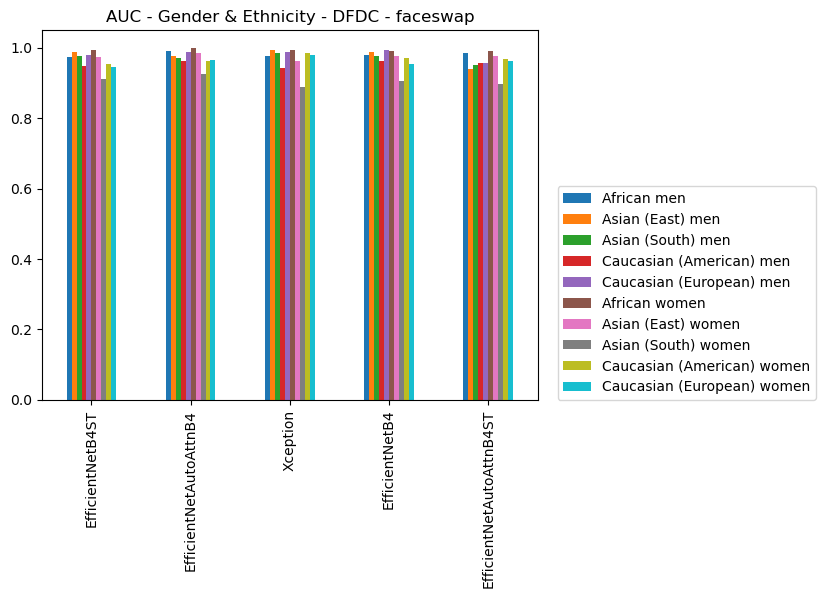

In [84]:
temp_df = gender_eth_accuracy_df[gender_eth_accuracy_df['training_dataset'] == 'DFDC']
af_auc_m = []
ca_auc_m = []
ce_auc_m = []
ae_auc_m = []
as_auc_m = []
af_auc_f = []
ca_auc_f = []
ce_auc_f = []
ae_auc_f = []
as_auc_f = []

model_names = [m.split('_')[0] for m in df_dict.keys()]
model_names = list(set(model_names))
for model in model_names:
    cond = (temp_df['model']==model) & (temp_df['ethnicity']=='African') & (temp_df['gender'] == 'men')
    af_auc_m.append(temp_df[cond]['auc-roc'].values[0])
    cond = (temp_df['model']==model) & (temp_df['ethnicity']=='Asian (East)') & (temp_df['gender'] == 'men')
    ae_auc_m.append(temp_df[cond]['auc-roc'].values[0])
    cond = (temp_df['model']==model) & (temp_df['ethnicity']=='Asian (South)') & (temp_df['gender'] == 'men')
    as_auc_m.append(temp_df[cond]['auc-roc'].values[0])
    cond = (temp_df['model']==model) & (temp_df['ethnicity']=='Caucasian (American)') & (temp_df['gender'] == 'men')
    ca_auc_m.append(temp_df[cond]['auc-roc'].values[0])
    cond = (temp_df['model']==model) & (temp_df['ethnicity']=='Caucasian (European)') & (temp_df['gender'] == 'men')
    ce_auc_m.append(temp_df[cond]['auc-roc'].values[0])
    
    cond = (temp_df['model']==model) & (temp_df['ethnicity']=='African') & (temp_df['gender'] == 'women')
    af_auc_f.append(temp_df[cond]['auc-roc'].values[0])
    cond = (temp_df['model']==model) & (temp_df['ethnicity']=='Asian (East)') & (temp_df['gender'] == 'women')
    ae_auc_f.append(temp_df[cond]['auc-roc'].values[0])
    cond = (temp_df['model']==model) & (temp_df['ethnicity']=='Asian (South)') & (temp_df['gender'] == 'women')
    as_auc_f.append(temp_df[cond]['auc-roc'].values[0])
    cond = (temp_df['model']==model) & (temp_df['ethnicity']=='Caucasian (American)') & (temp_df['gender'] == 'women')
    ca_auc_f.append(temp_df[cond]['auc-roc'].values[0])
    cond = (temp_df['model']==model) & (temp_df['ethnicity']=='Caucasian (European)') & (temp_df['gender'] == 'women')
    ce_auc_f.append(temp_df[cond]['auc-roc'].values[0])
    
d_b = pd.DataFrame({
    'African men':af_auc_m,
    'Asian (East) men':ae_auc_m,
    'Asian (South) men':as_auc_m,
    'Caucasian (American) men':ca_auc_m,
    'Caucasian (European) men':ce_auc_m,
    'African women':af_auc_f,
    'Asian (East) women':ae_auc_f,
    'Asian (South) women':as_auc_f,
    'Caucasian (American) women':ca_auc_f,
    'Caucasian (European) women':ce_auc_f,
})
d_b.index = model_names
d_b.plot.bar(title = 'AUC - Gender & Ethnicity - DFDC - faceswap')
plt.legend(loc=(1.04,0))
plt.show()

In [80]:
temp_df = gender_eth_accuracy_df[gender_eth_accuracy_df['training_dataset'] == 'DFDC']
cols_to_select = ['model','ethnicity','gender','accuracy','auc-roc']
temp_dfs = []
model_names = [m.split('_')[0] for m in df_dict.keys()]
model_names = list(set(model_names))
for model in model_names:
    all_auc= temp_df[temp_df['model'] == model]['auc-roc'].values
    min_auc = min(all_auc)
    max_auc = max(all_auc)
    cond = (temp_df['auc-roc'] == min_auc) | (temp_df['auc-roc'] == max_auc)
    rows = temp_df[cond][cols_to_select].sort_values(by=['auc-roc'])
    rows = rows[rows['model'] == model]
    temp_dfs.append(rows)
    
for df_ in temp_dfs:
    print(df_)

               model      ethnicity gender  accuracy   auc-roc
87  EfficientNetB4ST  Asian (South)  women  0.820000  0.910800
85  EfficientNetB4ST        African  women  0.897727  0.993684
                     model      ethnicity gender  accuracy   auc-roc
27  EfficientNetAutoAttnB4  Asian (South)  women  0.820000  0.925600
25  EfficientNetAutoAttnB4        African  women  0.852273  0.999474
       model      ethnicity gender  accuracy   auc-roc
47  Xception  Asian (South)  women  0.770000  0.888000
45  Xception        African  women  0.965909  0.994737
            model             ethnicity gender  accuracy   auc-roc
7  EfficientNetB4         Asian (South)  women  0.840000  0.905200
4  EfficientNetB4  Caucasian (European)    men  0.814433  0.994468
                       model      ethnicity gender  accuracy   auc-roc
67  EfficientNetAutoAttnB4ST  Asian (South)  women  0.840000  0.896800
65  EfficientNetAutoAttnB4ST        African  women  0.931818  0.991579


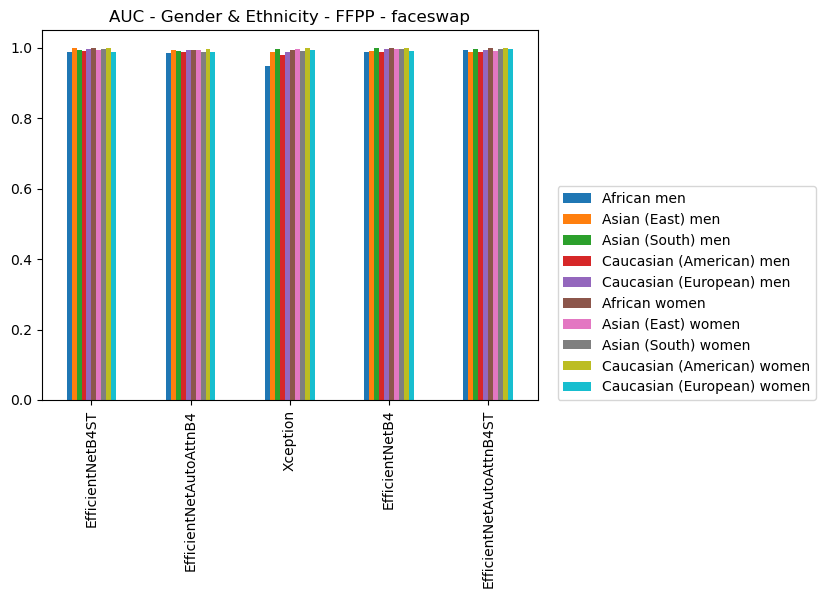

In [85]:
temp_df = gender_eth_accuracy_df[gender_eth_accuracy_df['training_dataset'] == 'FFPP']
af_auc_m = []
ca_auc_m = []
ce_auc_m = []
ae_auc_m = []
as_auc_m = []
af_auc_f = []
ca_auc_f = []
ce_auc_f = []
ae_auc_f = []
as_auc_f = []

model_names = [m.split('_')[0] for m in df_dict.keys()]
model_names = list(set(model_names))
for model in model_names:
    cond = (temp_df['model']==model) & (temp_df['ethnicity']=='African') & (temp_df['gender'] == 'men')
    af_auc_m.append(temp_df[cond]['auc-roc'].values[0])
    cond = (temp_df['model']==model) & (temp_df['ethnicity']=='Asian (East)') & (temp_df['gender'] == 'men')
    ae_auc_m.append(temp_df[cond]['auc-roc'].values[0])
    cond = (temp_df['model']==model) & (temp_df['ethnicity']=='Asian (South)') & (temp_df['gender'] == 'men')
    as_auc_m.append(temp_df[cond]['auc-roc'].values[0])
    cond = (temp_df['model']==model) & (temp_df['ethnicity']=='Caucasian (American)') & (temp_df['gender'] == 'men')
    ca_auc_m.append(temp_df[cond]['auc-roc'].values[0])
    cond = (temp_df['model']==model) & (temp_df['ethnicity']=='Caucasian (European)') & (temp_df['gender'] == 'men')
    ce_auc_m.append(temp_df[cond]['auc-roc'].values[0])
    
    cond = (temp_df['model']==model) & (temp_df['ethnicity']=='African') & (temp_df['gender'] == 'women')
    af_auc_f.append(temp_df[cond]['auc-roc'].values[0])
    cond = (temp_df['model']==model) & (temp_df['ethnicity']=='Asian (East)') & (temp_df['gender'] == 'women')
    ae_auc_f.append(temp_df[cond]['auc-roc'].values[0])
    cond = (temp_df['model']==model) & (temp_df['ethnicity']=='Asian (South)') & (temp_df['gender'] == 'women')
    as_auc_f.append(temp_df[cond]['auc-roc'].values[0])
    cond = (temp_df['model']==model) & (temp_df['ethnicity']=='Caucasian (American)') & (temp_df['gender'] == 'women')
    ca_auc_f.append(temp_df[cond]['auc-roc'].values[0])
    cond = (temp_df['model']==model) & (temp_df['ethnicity']=='Caucasian (European)') & (temp_df['gender'] == 'women')
    ce_auc_f.append(temp_df[cond]['auc-roc'].values[0])
    
d_b = pd.DataFrame({
    'African men':af_auc_m,
    'Asian (East) men':ae_auc_m,
    'Asian (South) men':as_auc_m,
    'Caucasian (American) men':ca_auc_m,
    'Caucasian (European) men':ce_auc_m,
    'African women':af_auc_f,
    'Asian (East) women':ae_auc_f,
    'Asian (South) women':as_auc_f,
    'Caucasian (American) women':ca_auc_f,
    'Caucasian (European) women':ce_auc_f,
})
d_b.index = model_names
d_b.plot.bar(title = 'AUC - Gender & Ethnicity - FFPP - faceswap')
plt.legend(loc=(1.04,0))
plt.show()

In [81]:
temp_df = gender_eth_accuracy_df[gender_eth_accuracy_df['training_dataset'] == 'FFPP']
cols_to_select = ['model','ethnicity','gender','accuracy','auc-roc']
temp_dfs = []
model_names = [m.split('_')[0] for m in df_dict.keys()]
model_names = list(set(model_names))
for model in model_names:
    all_auc= temp_df[temp_df['model'] == model]['auc-roc'].values
    min_auc = min(all_auc)
    max_auc = max(all_auc)
    cond = (temp_df['auc-roc'] == min_auc) | (temp_df['auc-roc'] == max_auc)
    rows = temp_df[cond][cols_to_select].sort_values(by=['auc-roc'])
    rows = rows[rows['model'] == model]
    temp_dfs.append(rows)
    
for df_ in temp_dfs:
    print(df_)

               model             ethnicity gender  accuracy  auc-roc
39  EfficientNetB4ST  Caucasian (European)  women  0.930000   0.9884
38  EfficientNetB4ST  Caucasian (American)  women  0.956989   1.0000
                     model             ethnicity gender  accuracy   auc-roc
70  EfficientNetAutoAttnB4               African    men  0.946809  0.985455
78  EfficientNetAutoAttnB4  Caucasian (American)  women  0.956989  0.997674
       model             ethnicity gender  accuracy   auc-roc
90  Xception               African    men  0.872340  0.949545
98  Xception  Caucasian (American)  women  0.989247  1.000000
             model             ethnicity gender  accuracy   auc-roc
10  EfficientNetB4               African    men  0.957447  0.989545
15  EfficientNetB4               African  women  0.954545  1.000000
18  EfficientNetB4  Caucasian (American)  women  0.967742  1.000000
                       model             ethnicity gender  accuracy   auc-roc
53  EfficientNetAutoAttnB4ST 

<ipython-input-166-1ef489c3b856>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp_df['subgroup'] = [x+' ' + y for x,y in zip(temp_df['ethnicity'].values,temp_df['gender'].values)]


<AxesSubplot:title={'center':'AUC Gender & Ethnicity DFDC_FFPP Faceswap'}, xlabel='subgroup'>

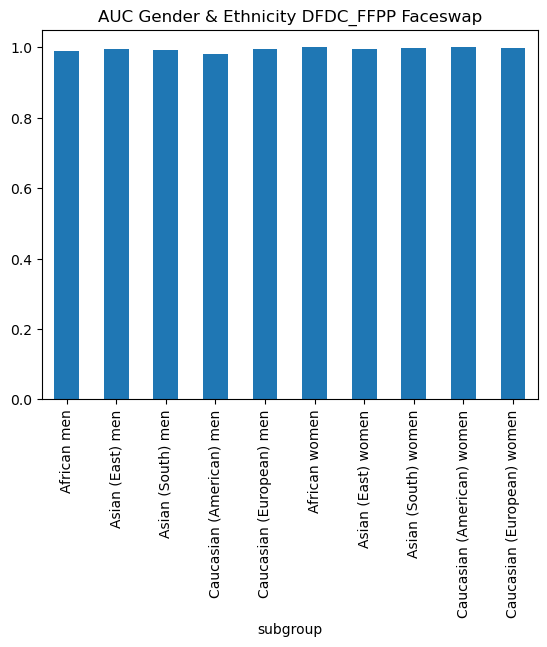

In [166]:
temp_df = gender_eth_accuracy_df[gender_eth_accuracy_df['training_dataset'] == 'DFDC_FFPP']
temp_df['subgroup'] = [x+' ' + y for x,y in zip(temp_df['ethnicity'].values,temp_df['gender'].values)]
temp_df.plot.bar(x='subgroup',y='auc-roc',title='AUC Gender & Ethnicity DFDC_FFPP Faceswap',legend=False)

#### Groups with low to high accuracy ( models trained on DFDC )

In [65]:
temp_df = gender_eth_accuracy_df[gender_eth_accuracy_df['training_dataset'] == 'DFDC']
temp_df.sort_values(by=['auc-roc'])

,model,training_dataset,gender,ethnicity,accuracy,precision_0,precision_1,recall_0,recall_1,f1_0,f1_1,tpr,fpr,thresholds-roc,auc-roc
47,Xception,DFDC,women,Asian (South),0.770000,0.775510,0.764706,0.76,0.780000,0.767677,0.772277,"[0.0, 0.02, 0.36, 0.36, 0.42, 0.42, 0.6, 0.6, ...","[0.0, 0.0, 0.0, 0.02, 0.02, 0.04, 0.04, 0.06, ...","[1.9989504999999999, 0.9989505, 0.97955143, 0....",0.888000
67,EfficientNetAutoAttnB4ST,DFDC,women,Asian (South),0.840000,0.814815,0.869565,0.88,0.800000,0.846154,0.833333,"[0.0, 0.02, 0.52, 0.52, 0.7, 0.7, 0.76, 0.76, ...","[0.0, 0.0, 0.0, 0.02, 0.02, 0.04, 0.04, 0.06, ...","[1.9768653999999999, 0.9768654, 0.91205496, 0....",0.896800
7,EfficientNetB4,DFDC,women,Asian (South),0.840000,0.869565,0.814815,0.80,0.880000,0.833333,0.846154,"[0.0, 0.02, 0.38, 0.38, 0.46, 0.46, 0.58, 0.58...","[0.0, 0.0, 0.0, 0.02, 0.02, 0.08, 0.08, 0.1, 0...","[1.9993001000000001, 0.9993001, 0.9912219, 0.9...",0.905200
87,EfficientNetB4ST,DFDC,women,Asian (South),0.820000,0.833333,0.807692,0.80,0.840000,0.816327,0.823529,"[0.0, 0.02, 0.34, 0.34, 0.6, 0.6, 0.68, 0.68, ...","[0.0, 0.0, 0.0, 0.02, 0.02, 0.04, 0.04, 0.1, 0...","[1.97755253, 0.97755253, 0.9432201, 0.930991, ...",0.910800
27,EfficientNetAutoAttnB4,DFDC,women,Asian (South),0.820000,0.847826,0.796296,0.78,0.860000,0.812500,0.826923,"[0.0, 0.02, 0.38, 0.38, 0.58, 0.58, 0.7, 0.7, ...","[0.0, 0.0, 0.0, 0.02, 0.02, 0.04, 0.04, 0.06, ...","[1.9992391, 0.9992391, 0.9871272, 0.9869153, 0...",0.925600
61,EfficientNetAutoAttnB4ST,DFDC,men,Asian (East),0.759036,1.000000,0.622642,0.60,1.000000,0.750000,0.767442,"[0.0, 0.030303030303030304, 0.4545454545454545...","[0.0, 0.0, 0.0, 0.04, 0.04, 0.06, 0.06, 0.08, ...","[1.97796327, 0.97796327, 0.94036597, 0.9359528...",0.940606
43,Xception,DFDC,men,Caucasian (American),0.890000,0.933333,0.854545,0.84,0.940000,0.884211,0.895238,"[0.0, 0.02, 0.38, 0.38, 0.44, 0.44, 0.66, 0.66...","[0.0, 0.0, 0.0, 0.02, 0.02, 0.04, 0.04, 0.06, ...","[1.99834216, 0.99834216, 0.98931676, 0.9883396...",0.943200
89,EfficientNetB4ST,DFDC,women,Caucasian (European),0.880000,0.931818,0.839286,0.82,0.940000,0.872340,0.886792,"[0.0, 0.02, 0.4, 0.4, 0.58, 0.58, 0.7, 0.7, 0....","[0.0, 0.0, 0.0, 0.02, 0.02, 0.04, 0.04, 0.06, ...","[1.9695507, 0.9695507, 0.9418315, 0.94048065, ...",0.944800
83,EfficientNetB4ST,DFDC,men,Caucasian (American),0.820000,0.970588,0.742424,0.66,0.980000,0.785714,0.844828,"[0.0, 0.02, 0.66, 0.66, 0.72, 0.72, 0.82, 0.82...","[0.0, 0.0, 0.0, 0.02, 0.02, 0.06, 0.06, 0.1, 0...","[1.97870684, 0.97870684, 0.914207, 0.9057066, ...",0.947600
62,EfficientNetAutoAttnB4ST,DFDC,men,Asian (South),0.770000,0.965517,0.690141,0.56,0.980000,0.708861,0.809917,"[0.0, 0.02, 0.4, 0.4, 0.7, 0.7, 0.86, 0.86, 0....","[0.0, 0.0, 0.0, 0.02, 0.02, 0.04, 0.04, 0.06, ...","[1.9748730700000001, 0.97487307, 0.9452732, 0....",0.951600


#### Groups with low to high accuracy ( models trained on FFPP )

In [66]:
temp_df = gender_eth_accuracy_df[gender_eth_accuracy_df['training_dataset'] == 'FFPP']
temp_df.sort_values(by=['auc-roc'])

,model,training_dataset,gender,ethnicity,accuracy,precision_0,precision_1,recall_0,recall_1,f1_0,f1_1,tpr,fpr,thresholds-roc,auc-roc
90,Xception,FFPP,men,African,0.872340,0.827586,0.944444,0.96,0.772727,0.888889,0.850000,"[0.0, 0.022727272727272728, 0.6136363636363636...","[0.0, 0.0, 0.0, 0.02, 0.02, 0.04, 0.04, 0.08, ...","[1.9900575, 0.9900575, 0.83139926, 0.7977816, ...",0.949545
93,Xception,FFPP,men,Caucasian (American),0.940000,0.940000,0.940000,0.94,0.940000,0.940000,0.940000,"[0.0, 0.02, 0.82, 0.82, 0.84, 0.84, 0.86, 0.86...","[0.0, 0.0, 0.0, 0.02, 0.02, 0.04, 0.04, 0.06, ...","[1.9966882, 0.9966882, 0.77894914, 0.77811664,...",0.980400
70,EfficientNetAutoAttnB4,FFPP,men,African,0.946809,0.924528,0.975610,0.98,0.909091,0.951456,0.941176,"[0.0, 0.022727272727272728, 0.5454545454545454...","[0.0, 0.0, 0.0, 0.02, 0.02, 0.06, 0.06, 0.12, ...","[1.9919310000000001, 0.991931, 0.83069927, 0.7...",0.985455
79,EfficientNetAutoAttnB4,FFPP,women,Caucasian (European),0.950000,0.959184,0.941176,0.94,0.960000,0.949495,0.950495,"[0.0, 0.02, 0.64, 0.64, 0.88, 0.88, 0.92, 0.92...","[0.0, 0.0, 0.0, 0.02, 0.02, 0.04, 0.04, 0.06, ...","[1.9977393, 0.9977393, 0.96251744, 0.9613452, ...",0.987200
53,EfficientNetAutoAttnB4ST,FFPP,men,Caucasian (American),0.960000,0.960000,0.960000,0.96,0.960000,0.960000,0.960000,"[0.0, 0.02, 0.96, 0.96, 0.98, 0.98, 1.0, 1.0]","[0.0, 0.0, 0.0, 0.14, 0.14, 0.5, 0.5, 1.0]","[1.97264594, 0.97264594, 0.61952895, 0.2807327...",0.987200
51,EfficientNetAutoAttnB4ST,FFPP,men,Asian (East),0.927711,1.000000,0.846154,0.88,1.000000,0.936170,0.916667,"[0.0, 0.030303030303030304, 0.7878787878787878...","[0.0, 0.0, 0.0, 0.02, 0.02, 0.04, 0.04, 0.06, ...","[1.9742244, 0.9742244, 0.82044315, 0.81034005,...",0.987879
91,Xception,FFPP,men,Asian (East),0.939759,0.978723,0.888889,0.92,0.969697,0.948454,0.927536,"[0.0, 0.030303030303030304, 0.7272727272727273...","[0.0, 0.0, 0.0, 0.04, 0.04, 0.08, 0.08, 1.0]","[1.9951688600000002, 0.99516886, 0.92095387, 0...",0.987879
39,EfficientNetB4ST,FFPP,women,Caucasian (European),0.930000,0.957447,0.905660,0.90,0.960000,0.927835,0.932039,"[0.0, 0.02, 0.76, 0.76, 0.88, 0.88, 0.94, 0.94...","[0.0, 0.0, 0.0, 0.02, 0.02, 0.04, 0.04, 0.08, ...","[1.9863332, 0.9863332, 0.87243587, 0.83802176,...",0.988400
73,EfficientNetAutoAttnB4,FFPP,men,Caucasian (American),0.970000,0.979592,0.960784,0.96,0.980000,0.969697,0.970297,"[0.0, 0.02, 0.86, 0.86, 0.98, 0.98, 1.0, 1.0]","[0.0, 0.0, 0.0, 0.04, 0.04, 0.34, 0.34, 1.0]","[1.99364215, 0.99364215, 0.6969652, 0.6732504,...",0.988400
94,Xception,FFPP,men,Caucasian (European),0.927835,0.957447,0.900000,0.90,0.957447,0.927835,0.927835,"[0.0, 0.02127659574468085, 0.9148936170212766,...","[0.0, 0.0, 0.0, 0.04, 0.04, 0.06, 0.06, 0.2, 0...","[1.9950611999999999, 0.9950612, 0.73882556, 0....",0.988511


#### Groups with low to high accuracy ( models trained on both DFDC and FFPP )

In [167]:
temp_df = gender_eth_accuracy_df[gender_eth_accuracy_df['training_dataset'] == 'DFDC_FFPP']
temp_df.sort_values(by=['auc-roc'])

,model,training_dataset,gender,ethnicity,accuracy,precision_0,precision_1,recall_0,recall_1,f1_0,f1_1,tpr,fpr,thresholds-roc,auc-roc
103,CrossEffViT,DFDC_FFPP,men,Caucasian (American),0.940000,0.978261,0.907407,0.90,0.98,0.937500,0.942308,"[0.0, 0.02, 0.78, 0.78, 0.9, 0.9, 0.96, 0.96, ...","[0.0, 0.0, 0.0, 0.02, 0.02, 0.04, 0.04, 0.06, ...","[1.99995714, 0.99995714, 0.96362114, 0.9606824...",0.982400
100,CrossEffViT,DFDC_FFPP,men,African,0.904255,1.000000,0.830189,0.82,1.00,0.901099,0.907216,"[0.0, 0.022727272727272728, 0.6818181818181818...","[0.0, 0.0, 0.0, 0.02, 0.02, 0.04, 0.04, 1.0]","[1.99995816, 0.99995816, 0.99701655, 0.9951516...",0.990000
102,CrossEffViT,DFDC_FFPP,men,Asian (South),0.930000,0.957447,0.905660,0.90,0.96,0.927835,0.932039,"[0.0, 0.02, 0.9, 0.9, 0.92, 0.92, 0.94, 0.94, ...","[0.0, 0.0, 0.0, 0.02, 0.02, 0.08, 0.08, 0.1, 0...","[1.99995923, 0.99995923, 0.94028854, 0.8073393...",0.992000
106,CrossEffViT,DFDC_FFPP,women,Asian (East),0.908046,1.000000,0.822222,0.84,1.00,0.913043,0.902439,"[0.0, 0.02702702702702703, 0.7297297297297297,...","[0.0, 0.0, 0.0, 0.02, 0.02, 1.0]","[1.9999617, 0.9999617, 0.9698133, 0.9695839, 0...",0.994595
101,CrossEffViT,DFDC_FFPP,men,Asian (East),0.939759,1.000000,0.868421,0.90,1.00,0.947368,0.929577,"[0.0, 0.030303030303030304, 0.8181818181818182...","[0.0, 0.0, 0.0, 0.02, 0.02, 1.0]","[1.9999607, 0.9999607, 0.9969868, 0.99694365, ...",0.996364
104,CrossEffViT,DFDC_FFPP,men,Caucasian (European),0.948454,1.000000,0.903846,0.90,1.00,0.947368,0.949495,"[0.0, 0.02127659574468085, 0.8936170212765957,...","[0.0, 0.0, 0.0, 0.02, 0.02, 0.06, 0.06, 1.0]","[1.9999637, 0.9999637, 0.92935956, 0.9110939, ...",0.997021
107,CrossEffViT,DFDC_FFPP,women,Asian (South),0.960000,1.000000,0.925926,0.92,1.00,0.958333,0.961538,"[0.0, 0.02, 0.94, 0.94, 1.0, 1.0]","[0.0, 0.0, 0.0, 0.02, 0.02, 1.0]","[1.9999581, 0.9999581, 0.9600475, 0.952275, 0....",0.998800
109,CrossEffViT,DFDC_FFPP,women,Caucasian (European),0.970000,1.000000,0.943396,0.94,1.00,0.969072,0.970874,"[0.0, 0.02, 0.96, 0.96, 1.0, 1.0]","[0.0, 0.0, 0.0, 0.02, 0.02, 1.0]","[1.9999611000000002, 0.9999611, 0.918899, 0.91...",0.999200
105,CrossEffViT,DFDC_FFPP,women,African,0.954545,1.000000,0.904762,0.92,1.00,0.958333,0.950000,"[0.0, 0.02631578947368421, 0.05263157894736842...","[0.0, 0.0, 0.0, 0.0, 0.0, 1.0]","[1.9999555, 0.9999555, 0.999955, 0.99995214, 0...",1.000000
108,CrossEffViT,DFDC_FFPP,women,Caucasian (American),0.989247,1.000000,0.977273,0.98,1.00,0.989899,0.988506,"[0.0, 0.023255813953488372, 1.0, 1.0]","[0.0, 0.0, 0.0, 1.0]","[1.9999582, 0.9999582, 0.86915463, 0.00024685255]",1.000000
